# 🧠 Feature Engineering for Unusual User Behavior

## Introduction

This notebook explores **feature engineering for detecting unusual user behavior** (potential bots) in Google Ad Click datasets.
The goal is to create meaningful features that help distinguish between **normal human interactions** and **suspicious automated patterns**.

We follow a structured approach inspired by the **CRISP-DM methodology** combined with elements of **Design Thinking** to balance rigor and creativity:

1. **Business Understanding** – Why detecting bots matters for advertisers and users.
2. **Data Understanding** – Explore the dataset: user IDs, sessions, devices, and event sequences.
3. **Data Preparation** – Load, clean, and structure JSONL data for analysis.
4. **Feature Engineering (Core Focus)** – Extract both basic and advanced behavioral features:

   * Session activity counts and durations
   * Scroll depth and velocity
   * Touch and click diversity
   * Entropy and randomness of actions
   * Temporal irregularities in events
5. **Modeling Considerations** – Discuss anomaly detection models (Isolation Forest, One-Class SVM, Autoencoders).
6. **Evaluation & Next Steps** – Outline how features could be validated and deployed.

Throughout the notebook, we will use **visualizations, statistical summaries, and domain-inspired creativity** to engineer features that can reveal hidden patterns in user behavior.

---

📌 *Note:* This notebook does not aim to train a full predictive model, but rather to demonstrate strong **feature engineering and analytical thinking**, which form the foundation for anomaly detection in digital advertising.


## Business Understanding

Digital advertising faces a recurring challenge: **bots generating fake ad clicks**.  
This creates two major business problems:

- **Financial impact:** Advertisers waste budget on non-human clicks that will never convert.  
- **Analytical distortion:** Metrics like CTR (Click-Through Rate) and conversion rates become unreliable when bot traffic is mixed with genuine user behavior.

The objective of this project is to **engineer features that capture unusual or suspicious behavioral patterns** in user sessions. These features will later serve as the foundation for anomaly detection models.

### Success Criteria
- Features should highlight **differences between human and automated behavior** in measurable ways (e.g., action diversity, timing irregularities, scroll depth).  
- Engineered features must be **interpretable** and provide value even without labeled data.  
- Anomaly detection results should surface **plausible bot-like sessions** for further review.

### Constraints & Considerations
- The dataset represents **a single day for one customer** – patterns may be limited in scope.  
- There are **no explicit labels for bots**, requiring an **unsupervised approach**.  
- A key risk is **false positives**: misclassifying genuine users as bots. Features need to balance sensitivity with reliability.


## Data Loading & Initial Inspection

The dataset is provided in **JSONL (JSON Lines)** format, where each line represents one record.  
Each record contains information about:
- **User & session identifiers** (`tcid`, `session_id`, `tbid`)  
- **Device & browser details** (`device`, `screen`, `viewport`, `user_agent`)  
- **Timestamps** (`created_at`, `happened_at` inside events)  
- **Events** (sequence of actions: scrolls, clicks, touches, resizes, visibility changes, etc.)  

We will first load the data into a Pandas DataFrame and inspect its structure.


In [1]:
import json
from pprint import pprint
import pandas as pd
from pathlib import Path

In [2]:
file_path = "/content/public_group_01_14_02_04.jsonl"

records = []
with open(file_path, "r") as f:
    for line in f:
      json.loads(line)
      records.extend(json.loads(line))

df = pd.json_normalize(records)
print("Shape: ", df.shape)
df.head(2)

Shape:  (6505, 13)


,hostname,tbid,tcid,created_at,user_agent,clid,events,device,converted,screen.width,screen.height,viewport.width,viewport.height
0,www.public.gr,29f79081-1057-43b2-b22d-8260ff55d80e,06046a82-f99f-46a6-b67f-8999d24c1423,2025-02-25T17:31:39.031000,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_1 like...,Cj0KCQiA8fW9BhC8ARIsACwHqYpBYgHdkVuP3QdnJFcVAo...,"[{'_id': None, 'tcid': '06046a82-f99f-46a6-b67...",m,False,393,852,393,773
1,www.public.gr,ff6ad41b-5f8f-4ba7-a30d-d27625fae06d,44d62259-c6d3-49ff-8346-e1d5ddff802e,2025-02-25T05:15:14.398000,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,CjwKCAiAzvC9BhADEiwAEhtlN-9Sejruwxy9-TtOyiGYYp...,"[{'_id': None, 'tcid': '44d62259-c6d3-49ff-834...",m,False,384,857,384,784


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6505 entries, 0 to 6504
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   hostname         6505 non-null   object
 1   tbid             6505 non-null   object
 2   tcid             6505 non-null   object
 3   created_at       6505 non-null   object
 4   user_agent       6505 non-null   object
 5   clid             6505 non-null   object
 6   events           6505 non-null   object
 7   device           5801 non-null   object
 8   converted        6505 non-null   bool  
 9   screen.width     6505 non-null   int64 
 10  screen.height    6505 non-null   int64 
 11  viewport.width   6505 non-null   int64 
 12  viewport.height  6505 non-null   int64 
dtypes: bool(1), int64(4), object(8)
memory usage: 616.3+ KB


In [4]:
print(df['device'].unique())

['m' None 'c' 't']


## Data Inspection

After flattening the JSONL file, the dataset contains **6,505 tab sessions** across all users.  
Each row corresponds to a **single tab opened by a user**, which includes metadata and a sequence of recorded events.

### Dataset Overview
- **User & Session identifiers**
  - `tcid` → unique user ID
  - `tbid` → tab ID
  - `session_id` (inside events, not top-level) → logical session splits (30 min rule)

- **Device & Environment**
  - `device` → device type (`m = mobile`, `c = desktop`, `t = tablet`)
  - `screen.*` and `viewport.*` → dimensions of screen and browser viewport
  - `user_agent` → detailed browser/device string

- **Timestamps**
  - `created_at` → time of the ad click
  - `happened_at` (inside events) → exact timing of each user action

- **Behavior**
  - `events` → nested list of user actions (scroll, click, touch, resize, visibility changes)

- **Target**
  - `converted` → whether the ad click converted (**to be ignored** in this task)

### Data Quality Notes
- **Device column:** 704 missing values (≈10.8%).
- **Events column:** non-null but nested → needs to be exploded into a separate event-level DataFrame.
- **Timestamps:** currently strings → must be parsed as datetime objects for temporal analysis.


### Missing Values Overview

Before diving into feature engineering, it’s important to understand missingness in the dataset.  
We will not fix missing values immediately, but rather investigate how they are distributed.  
This helps determine whether missingness is random noise or potentially a **signal of unusual behavior** (e.g., bots with incomplete metadata).


In [5]:
device_column = df['device']
print(device_column.isna().sum())
print(device_column.isna().sum() / len(device_column) *100)

704
10.822444273635664


## Exploratory Data Analysis (EDA) – Session Level

We begin with a **tab/session-level exploration** before drilling down into detailed event sequences.  
This helps establish baseline behavior and highlight potential anomalies in:

- User activity (tabs per user)  
- Temporal activity (when clicks occur)  
- Device usage patterns  

Such patterns give context and guide which features will be most useful for detecting unusual sessions.


### Tabs per User

In [6]:
n_users = df['tcid'].unique()
n_tabs = df['tbid'].unique()

print(f"Number of users: {len(n_users)}")
print(f"Number of tabs: {len(n_tabs)}")

tabs_per_user = df.groupby('tcid')['tbid'].nunique()
tabs_per_user.describe()

Number of users: 2586
Number of tabs: 4498


,tbid
count,2586.000000
mean,1.739366
std,1.684648
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,23.000000


<Axes: title={'center': 'Distribution of Tabs per User'}, ylabel='Frequency'>

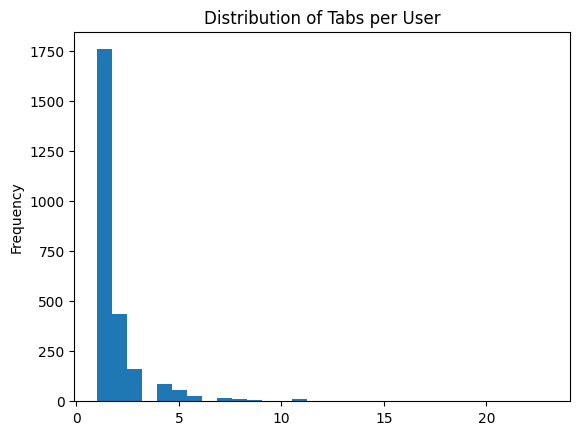

In [7]:
tabs_per_user.plot(kind="hist", bins=30, title="Distribution of Tabs per User")

The tab-per-user analysis reveals the following:

- **Total users**: 2,586  
- **Total tabs**: 4,498  
- **Median tabs per user**: 1 (most users open only a single tab)  
- **75th percentile**: 2 tabs  
- **Maximum**: 23 tabs opened by a single user  

This distribution is highly skewed:  
- The majority of users (≈75%) open just **1 tab**, which aligns with normal browsing behavior.  
- A small number of users open many tabs (up to **23**), which is unusual and could indicate **automated or abnormal activity**.  

### Tabs Creation Hour

In [8]:
df['created_at'] = pd.to_datetime(df['created_at'], format="ISO8601")
created_at_hour = df['created_at'].dt.hour
created_at_hour.describe()

,created_at
count,6505.000000
mean,13.862721
std,5.031427
min,0.000000
25%,10.000000
50%,14.000000
75%,18.000000
max,23.000000


<Axes: title={'center': 'Distribution of Ad Clicks by Hour'}, ylabel='Frequency'>

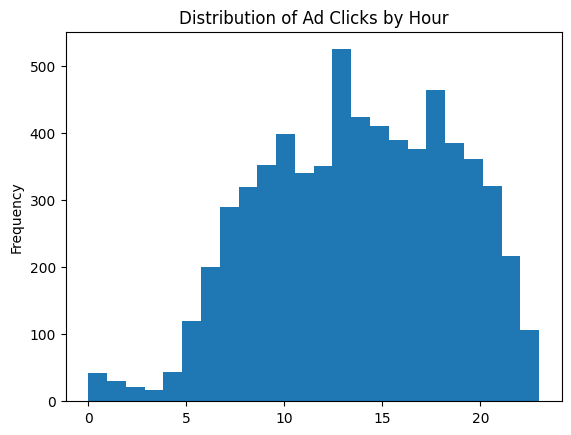

In [9]:
created_at_hour.plot(kind='hist', bins=24, title="Distribution of Ad Clicks by Hour")

## created at

### Device

In [10]:
device_filled = df['device'].fillna('unknown')
device_counts = device_filled.value_counts(normalize=True) * 100
device_counts

,proportion
device,
m,67.378939
c,20.522675
unknown,10.822444
t,1.275942


<Axes: title={'center': "Distribution of Device Types (including 'unknown')"}, xlabel='Device Type', ylabel='Number of Sessions'>

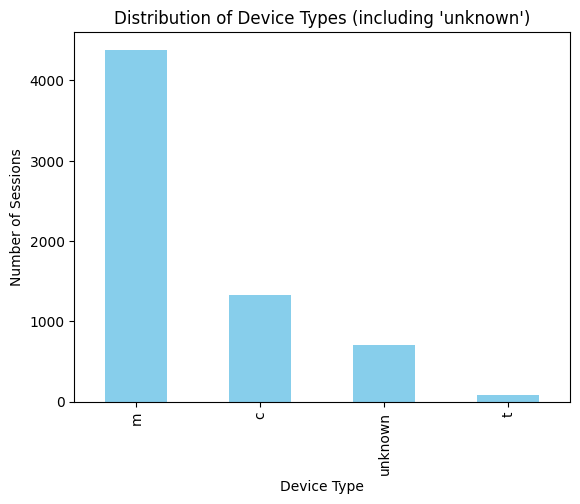

In [11]:
device_filled.value_counts().plot(kind='bar', color='skyblue', xlabel='Device Type', ylabel='Number of Sessions', title="Distribution of Device Types (including 'unknown')")

The device distribution shows that the majority of sessions come from **mobile devices (≈67%)**, followed by **desktop (≈21%)**.  
Tablets account for only **~1%** of sessions, while **~11% of sessions have missing device information**, which we labeled as **"unknown"**.

This breakdown is consistent with typical user behavior where mobile dominates online browsing.  
However, the relatively high proportion of **unknown device sessions** may be worth attention — incomplete or missing device metadata could be a potential indicator of **bot-generated activity**.


### Screen vs. Viewport Dimensions

Each session records both the **screen size** (`screen.width`, `screen.height`) and the **viewport size** (`viewport.width`, `viewport.height`).

- **Screen** = the full device display resolution.  
- **Viewport** = the visible browser area (excludes browser UI, toolbars, etc.).  

By comparing the viewport area to the screen area, we can compute the **viewport ratio**

#### Why it matters
- **Humans** usually have viewport ratios close to typical values (e.g., 0.6 – 1.0).  
- **Bots/headless browsers** may have unrealistic ratios (very small, very large, or constant values across sessions).  
- This makes viewport ratio a useful feature for detecting unusual browsing environments.


In [12]:
screen_area = df['screen.width'] * df['screen.height']
viewport_area = df['viewport.width'] * df['viewport.height']
viewport_ratio = viewport_area / screen_area

viewport_ratio.describe()

,0
count,6505.000000
mean,0.854676
std,0.183014
min,0.000000
25%,0.804502
50%,0.847775
75%,0.902994
max,7.850414


<Axes: title={'center': 'Distribution of Viewport Ratios'}, xlabel='Viewport / Screen Ratio', ylabel='Number of Sessions'>

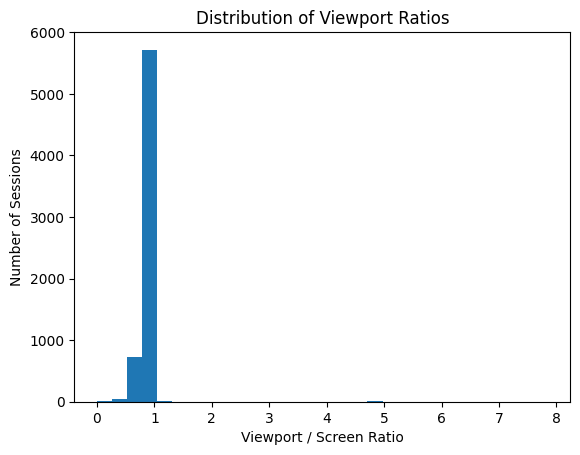

In [13]:
viewport_ratio.plot(kind='hist', bins=30, xlabel='Viewport / Screen Ratio', ylabel='Number of Sessions', title="Distribution of Viewport Ratios")

The viewport ratio analysis shows the following patterns:

- **Typical range**: Most sessions fall between **0.80 and 0.90**, with a median around **0.85**.  
  This is expected since browser viewports are usually slightly smaller than the full screen area.  

- **Unusual cases**:  
  - A minimum of **0.0** indicates some sessions where the viewport was recorded as empty or invalid.  
  - A maximum of **7.85** is far outside the expected range (ratios above 1 should not normally occur).  
  - These anomalies may correspond to **data errors, bots, or non-standard environments**.  

Overall, the feature is promising: while most values cluster in a realistic human range, the presence of extreme outliers could serve as a strong indicator of **suspicious activity**.


## Event-Level Exploration

Each tab/session contains a sequence of **events** that record user interactions.

By exploding the nested `events` into a separate event-level DataFrame, we can analyze the distribution and patterns of user actions.  
This step is critical, since **user interaction behavior** is often the strongest signal for distinguishing humans from bots.


In [14]:
events_expanded = df.explode('events').reset_index(drop=True)

events_df = pd.json_normalize(events_expanded['events'])

tab_created_at = events_expanded[['created_at']].rename(columns={'created_at': 'tab_created_at'})
events_df = pd.concat([tab_created_at, events_df], axis=1)

print("Shape: ", events_df.shape)
display(events_df.head(2))

Shape:  (1613523, 21)


,tab_created_at,_id,tcid,session_id,tbid,event_type,position_x,position_y,touch_count,happened_at,...,updated_at,scroll_depth,visibility,width,height,element_selector,url,error,key_pressed,value
0,2025-02-25 17:31:39.031,None,06046a82-f99f-46a6-b67f-8999d24c1423,None,29f79081-1057-43b2-b22d-8260ff55d80e,TOUCH_START,310.0,361.0,1.0,2025-02-25T17:33:16.867000,...,2025-02-25T17:33:20.822000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-02-25 17:31:39.031,None,06046a82-f99f-46a6-b67f-8999d24c1423,None,29f79081-1057-43b2-b22d-8260ff55d80e,SCROLL,NaN,NaN,NaN,2025-02-25T17:33:04.355000,...,2025-02-25T17:33:10.114000,4030.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1613523 entries, 0 to 1613522
Data columns (total 21 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   tab_created_at    1613523 non-null  datetime64[ns]
 1   _id               0 non-null        object        
 2   tcid              1613523 non-null  object        
 3   session_id        0 non-null        object        
 4   tbid              1613523 non-null  object        
 5   event_type        1613523 non-null  object        
 6   position_x        927548 non-null   float64       
 7   position_y        927548 non-null   float64       
 8   touch_count       737495 non-null   float64       
 9   happened_at       1613523 non-null  object        
 10  created_at        1613523 non-null  object        
 11  updated_at        1613523 non-null  object        
 12  scroll_depth      181095 non-null   float64       
 13  visibility        16956 non-null    object

In [16]:
events_df = events_df.drop(columns=['_id', 'session_id'])

events_df['happened_at'] = pd.to_datetime(events_df['happened_at'], format="ISO8601")
events_df['tab_created_at'] = pd.to_datetime(events_df['tab_created_at'], format="ISO8601")
events_df['created_at'] = pd.to_datetime(events_df['created_at'], format="ISO8601")
events_df['updated_at'] = pd.to_datetime(events_df['updated_at'], format="ISO8601")

events_df = events_df[[
    "tcid", "tbid", "tab_created_at", "created_at", "updated_at", "happened_at",
    "event_type", "position_x", "position_y", "touch_count", "scroll_depth",
    "visibility", "width", "height", "element_selector", "url",
    "error", "key_pressed", "value"
]]

events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1613523 entries, 0 to 1613522
Data columns (total 19 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   tcid              1613523 non-null  object        
 1   tbid              1613523 non-null  object        
 2   tab_created_at    1613523 non-null  datetime64[ns]
 3   created_at        1613523 non-null  datetime64[ns]
 4   updated_at        1613523 non-null  datetime64[ns]
 5   happened_at       1613523 non-null  datetime64[ns]
 6   event_type        1613523 non-null  object        
 7   position_x        927548 non-null   float64       
 8   position_y        927548 non-null   float64       
 9   touch_count       737495 non-null   float64       
 10  scroll_depth      181095 non-null   float64       
 11  visibility        16956 non-null    object        
 12  width             51938 non-null    float64       
 13  height            51938 non-null    float6

### Event Data Overview

After exploding the nested `events` field, we obtain a dataset of **1.6 million events** across all users and tabs.  
Each row now corresponds to a **single user interaction**.

#### Key Points:
- **Size**: 1,613,523 events (≈248 events per tab on average).  
- **Timestamps**: four time columns are available:
  - `tab_created_at` → when the tab was created (ad click).  
  - `happened_at` → when the event occurred.  
  - `created_at` / `updated_at` → logging times for the event.  
- **Event types**: captured in `event_type` (e.g., `SCROLL`, `TOUCH_START`, `CLICK`, `RESIZE`, etc.).  
- **Event-specific fields**:  
  - Position-based: `position_x`, `position_y`  
  - Touch gestures: `touch_count`  
  - Scrolling: `scroll_depth`  
  - Visibility: `visibility` (VISIBLE / HIDDEN)  
  - Window changes: `width`, `height`  
  - Click details: `element_selector`  
  - Navigation: `url`  
  - Errors / key presses / values  

#### Data Quality Notes:
- Many columns are **sparse** (e.g., `visibility` only 17k values, `scroll_depth` 181k values).  
  This is expected since most fields are event-type-specific.  
- The **core columns** present for all events are:
  - `tcid`, `tbid`, timestamps, and `event_type`.
- The richness of event types makes this dataset particularly well-suited for **behavioral feature engineering**.


### Event Type Distribution

The `event_type` column captures the type of user interaction.

Analyzing the distribution of event types helps us understand:
- **Typical human sessions** – usually include a mix of scrolling, clicks, and touches.  
- **Suspicious sessions** – may have repetitive patterns, e.g., excessive scrolling or clicks without variation.  

This provides a baseline for detecting unusual behaviors.


In [17]:
event_type_counts = events_df['event_type'].value_counts(normalize=True) * 100
event_type_counts

,proportion
event_type,
TOUCH_START,29.021278
TOUCH_MOVE,16.685848
MOUSE_MOVE,15.394946
SCROLL,11.060208
KEY_DOWN,3.891113
KEY_UP,3.515537
MOUSE_UP,3.222638
RESIZE,3.218919
MOUSE_DOWN,3.200946


<Axes: title={'center': 'Distribution of Event Types'}, xlabel='Event Type', ylabel='Number of Events'>

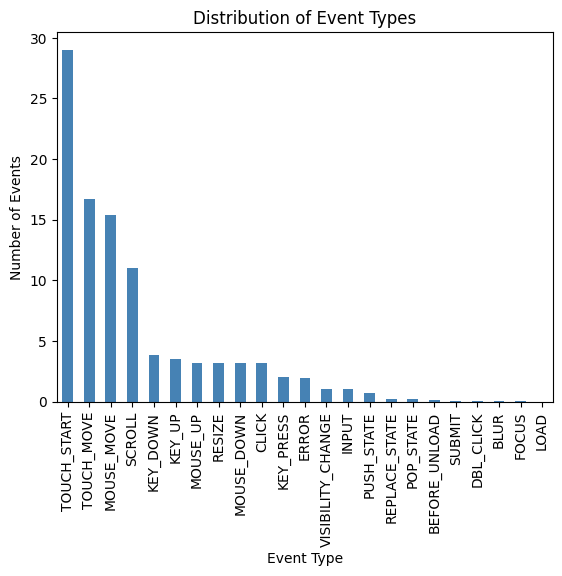

In [18]:
event_type_counts.plot(kind='bar', xlabel='Event Type', ylabel='Number of Events', title='Distribution of Event Types', color='steelblue')

The distribution of event types shows that a few categories dominate user interactions:

- **TOUCH events** are the most common, with **TOUCH_START (29%)** and **TOUCH_MOVE (17%)**, reflecting the high share of mobile sessions.  
- **MOUSE_MOVE (15%)** and **SCROLL (11%)** are also frequent, consistent with desktop interactions and natural browsing behavior.  
- **Clicks and key interactions** are relatively less common:
  - `CLICK` events account for only **~3%** of all actions.
  - `KEY_DOWN`, `KEY_UP`, and `KEY_PRESS` together make up about **9%**, which is expected since not every session involves typing.  
- **System/browser events** like `RESIZE` (3.2%) and `VISIBILITY_CHANGE` (1%) occur less often but can be useful signals—excessive frequency may suggest automation.  
- **Error-related events** (`ERROR`, `FAILED_TO_GET_ELEMENT`) represent about **2%** of events. These are worth monitoring since bots may trigger more errors.  
- Rare events like `PUSH_STATE`, `POP_STATE`, `SUBMIT`, and `DBL_CLICK` each contribute less than 1%.

#### Insight
- The distribution is **diverse**, which is typical of real human browsing.  
- Bots, on the other hand, may show **imbalanced patterns**, such as excessive scrolls or clicks with little variation.  

### Events per Tab / User

Each tab generates a sequence of events that reflects user activity.  
By examining the number of events per tab and per user, we can identify:

- **Normal behavior**: humans usually generate a moderate number of events (scrolling, clicking, typing) within a session.  
- **Suspicious behavior**: bots may produce **very few events** (e.g., just clicks) or **excessively many events** (e.g., continuous scrolling or repetitive touches).  

This analysis helps establish baseline ranges for normal interactions and flag outliers.


In [19]:
event_per_tab = events_df.groupby('tbid')['event_type'].count()
event_per_user = events_df.groupby('tcid')['event_type'].count()

print("Events per Tab:", event_per_tab.describe())
print("Events per User:", event_per_user.describe())

Events per Tab: count     4498.000000
mean       358.720098
std        928.417877
min          1.000000
25%         36.000000
50%         99.000000
75%        304.000000
max      24001.000000
Name: event_type, dtype: float64
Events per User: count     2586.000000
mean       623.945476
std       1650.002912
min          1.000000
25%         45.000000
50%        139.500000
75%        528.000000
max      35871.000000
Name: event_type, dtype: float64


<Axes: title={'center': 'Distribution of Events per Tab'}, xlabel='Number of Events per Tab', ylabel='Number of Tabs'>

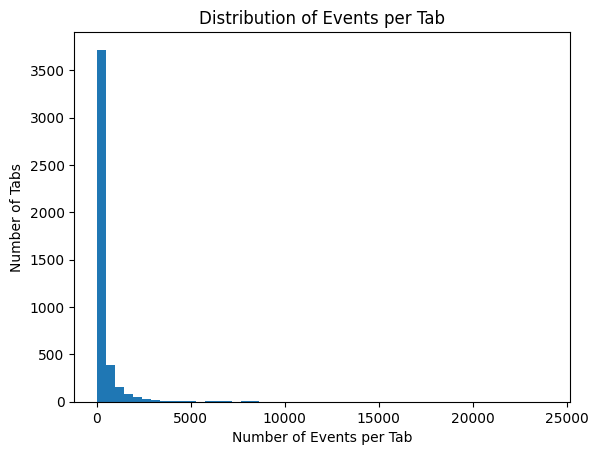

In [20]:
event_per_tab.plot(kind='hist', bins=50, title="Distribution of Events per Tab", xlabel='Number of Events per Tab', ylabel='Number of Tabs')

<Axes: title={'center': 'Distribution of Events per User'}, xlabel='Number of Events per User', ylabel='Number of Users'>

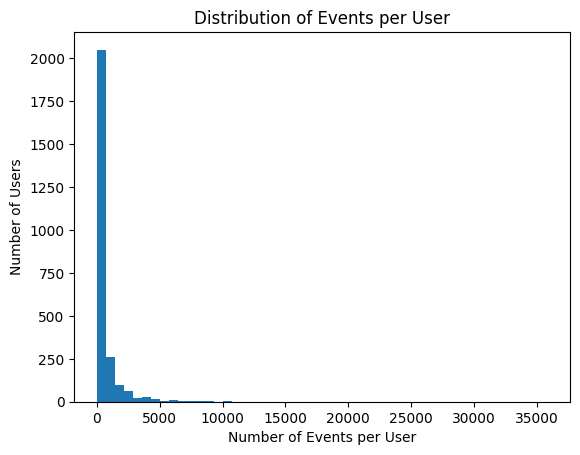

In [21]:
event_per_user.plot(kind='hist', bins=50, title="Distribution of Events per User", xlabel='Number of Events per User', ylabel='Number of Users')

The distribution of events per tab and per user shows strong variability:

#### Events per Tab
- **Median**: ~99 events per tab.  
- **25th–75th percentile**: between 36 and 304 events.  
- **Extreme outliers**: some tabs contain up to **24,001 events**, far above typical behavior.  

#### Events per User
- **Median**: ~140 events per user.  
- **25th–75th percentile**: between 45 and 528 events.  
- **Outliers**: the most active user generated **35,871 events** in a single day.  

#### Insights
- The heavy right tail in both distributions suggests the presence of **super-active sessions/users**, which are unusual compared to the majority.  

### Event Timing

Beyond event counts, the **timing of events** provides strong signals about user behavior:

- **Session length (per tab)**: duration between the first and last event.  
  - Humans typically browse for seconds to minutes.  
  - Bots may generate extremely short sessions (a few seconds) or long-running scripted loops.  

- **Inter-event gaps**: average time difference between consecutive events.  
  - Humans have irregular pauses (scroll, stop, think, click).  
  - Bots often show highly consistent, very short intervals.  


In [22]:
events_sorted_df = events_df.sort_values(['tbid', 'happened_at'])

session_length = events_sorted_df.groupby('tbid', group_keys=False)["happened_at"].apply(
    lambda x: (x.max() - x.min()).total_seconds()
)

inter_event_gaps = (
    events_sorted_df.groupby("tbid", group_keys=False)["happened_at"]
    .apply(lambda x: x.sort_values().diff().dropna().dt.total_seconds().mean())
)

print("Session Length per Tab (Seconds):")
display( session_length.describe())

print("\nMean Inter-Event Gap per Tab (Seconds):")
display(inter_event_gaps.describe())

Session Length per Tab (Seconds):


,happened_at
count,4498.000000
mean,1491.970202
std,11426.586879
min,0.000000
25%,18.013250
50%,62.127500
75%,282.846750
max,314590.799000



Mean Inter-Event Gap per Tab (Seconds):


,happened_at
count,4455.000000
mean,18.551819
std,301.885400
min,0.000000
25%,0.308636
50%,0.519483
75%,1.171489
max,13034.935667


<Axes: title={'center': 'Distribution of Session Lengths'}, xlabel='Session Length (seconds)', ylabel='Number of Tabs'>

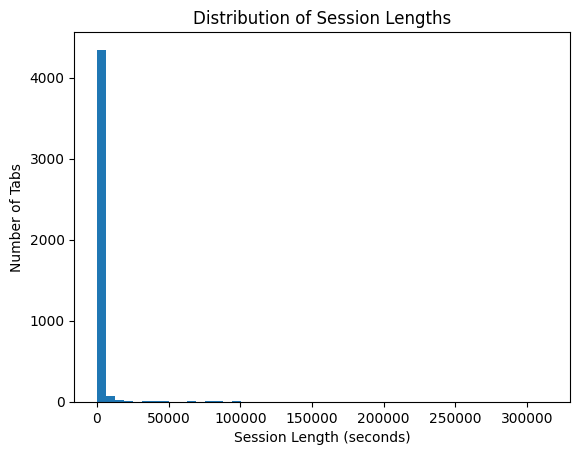

In [23]:
session_length.plot(kind='hist', bins=50, title="Distribution of Session Lengths", xlabel='Session Length (seconds)', ylabel='Number of Tabs')

<Axes: title={'center': 'Distribution of Inter-Event Gaps'}, xlabel='Inter-Event Gap (seconds)', ylabel='Number of Tabs'>

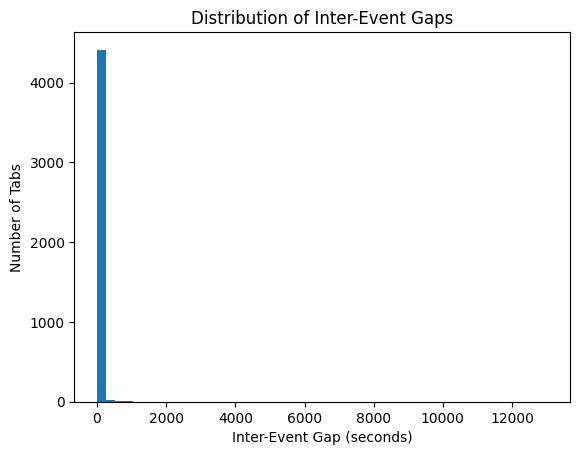

In [24]:
inter_event_gaps.plot(kind='hist', bins=50, title="Distribution of Inter-Event Gaps", xlabel='Inter-Event Gap (seconds)', ylabel='Number of Tabs')

The timing analysis highlights clear contrasts between typical and extreme behaviors:

#### Session Length (per Tab)
- **Median**: ~62 seconds  
- **Interquartile range (25%–75%)**: ~18 to 283 seconds (a few minutes)  
- **Outliers**: maximum session length exceeds **314,000 seconds (~87 hours)**, which is unrealistic for human browsing.  

#### Mean Inter-Event Gap (per Tab)
- **Median**: ~0.5 seconds between actions  
- **75%**: ~1.2 seconds  
- **Outliers**: some tabs show mean gaps of several hours (up to **13,000 seconds ≈ 3.6 hours**).  

#### Insights
- Most sessions behave **within realistic human ranges** (tens of seconds to a few minutes, with irregular pauses).  
- However, extreme outliers in both session length and inter-event gaps are strong indicators of **automated or abnormal activity**.  


### Scroll Behavior

Scrolling is one of the most natural signals of human browsing.  
By analyzing `SCROLL` events, we can capture several important behavioral patterns:

- **Scroll depth**: how far a user scrolls (in pixels).  
- **Maximum scroll depth per tab**: users often stop at varying points, while bots may consistently scroll to maximum depth.  
- **Scroll velocity**: rate of change in scroll depth over time.  
  - Humans → irregular scrolling, with pauses and variable speed.  
  - Bots → very fast or uniform scrolling.  

Abnormal or extreme scroll behaviors can therefore serve as strong indicators of automation.


In [25]:
scrolls = events_df[events_df['event_type'] == 'SCROLL'].copy()

scroll_depth_stats = scrolls['scroll_depth'].describe()
print('Scroll Depth Summary:')
display(scroll_depth_stats)

max_scroll_per_tab = scrolls.groupby('tbid')['scroll_depth'].max()
print("\nMax Scroll per Tab Summary:")
display(max_scroll_per_tab.describe())

Scroll Depth Summary:


,scroll_depth
count,178459.000000
mean,5335.952943
std,13087.342457
min,-110.000000
25%,331.303040
50%,1360.000000
75%,4212.000000
max,161172.000000



Max Scroll per Tab Summary:


,scroll_depth
count,3993.000000
mean,5083.016009
std,9403.775685
min,0.000000
25%,871.822205
50%,2346.000000
75%,5528.000000
max,161172.000000


<Axes: title={'center': 'Distribution of Maximum Scroll Depth per Tab'}, xlabel='Maximum Scroll Depth', ylabel='Number of Tabs'>

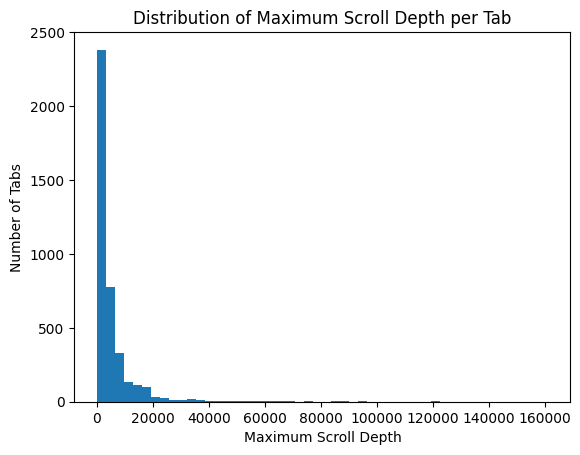

In [26]:
max_scroll_per_tab.plot(kind='hist', bins=50, title="Distribution of Maximum Scroll Depth per Tab", xlabel='Maximum Scroll Depth', ylabel='Number of Tabs')

In [27]:
def mean_scroll_velocity(group):
  group = group.sort_values('happened_at')
  depths = group['scroll_depth'].diff().dropna()
  times = group['happened_at'].diff().dt.total_seconds().dropna()
  if len(times) < 1:
    return 0
  velocity = depths / times.replace(0, float('nan'))
  return velocity.mean()

scroll_velocity = scrolls.groupby('tbid').apply(mean_scroll_velocity)
print("\nScroll Velocity Summary:")
display(scroll_velocity.describe())


Scroll Velocity Summary:


/tmp/ipython-input-3769848550.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  scroll_velocity = scrolls.groupby('tbid').apply(mean_scroll_velocity)


,0
count,3924.000000
mean,47.579523
std,183.990706
min,-2335.678473
25%,-17.759113
50%,24.672872
75%,108.142176
max,3731.997243


### Scroll Behavior Results

#### Scroll Depth
- **Median scroll depth**: ~1,360 pixels.  
- **Interquartile range**: 331 – 4,212 pixels.  
- **Outliers**: maximum depth reaches **161,172 pixels**, which is highly unusual and may reflect automated or synthetic scrolling.  
- Negative values (minimum = -110) suggest occasional logging errors or abnormal events.  

#### Maximum Scroll Depth per Tab
- **Median max depth per tab**: ~2,346 pixels.  
- **75th percentile**: ~5,528 pixels.  
- **Extreme values** (161k pixels) stand far outside normal browsing ranges and could be indicative of automation scripts.  

#### Scroll Velocity
- **Median**: ~25 pixels/second (reasonable for human scrolling).  
- **Interquartile range**: -18 to 108 pixels/second, showing variability and pauses typical of real users.  
- **Outliers**: velocities exceeding **3,700 px/s**, and even negative values (likely from rapid reverse scrolling or logging artifacts).  

#### Insights
- Normal human scrolls are moderate in depth and speed, with irregular variations.  
- Extremely high scroll depths and velocities are strong signals of **unnatural, potentially bot-driven sessions**.  


### Touch & Mouse Events

User interactions can be further analyzed by looking at **touch and mouse events**:

- **Touch events**: include `TOUCH_START` and `TOUCH_MOVE`, often accompanied by `touch_count`.  
- **Mouse events**: include `MOUSE_MOVE`, `MOUSE_DOWN`, `MOUSE_UP`, and `CLICK`, often with `position_x` and `position_y`.  

#### Why it matters
- **Device consistency**:  
  - Mobile sessions should mainly generate **touch events**.  
  - Desktop sessions should mainly generate **mouse events**.  
  - Inconsistencies (e.g., mouse events on mobile) may indicate automation.  

- **Event intensity**:  
  - Humans typically have modest numbers of touches or clicks.  
  - Bots may produce repetitive, high-volume interactions.  

- **Position variation**:  
  - Humans interact across varied screen areas.  
  - Bots may click in fixed or very limited regions.  


In [28]:
touch_events = events_df[events_df['event_type'].isin(['TOUCH_START', 'TOUCH_MOVE'])]
mouse_events = events_df[events_df['event_type'].isin(['MOUSE_MOVE', 'MOUSE_DOWN', 'MOUSE_UP'])]
clicks = events_df[events_df['event_type'] == 'CLICK']

print("Number of Touch Events: ", len(touch_events))
print("Number of Mouse Events: ", len(mouse_events))
print("Number of Click Events: ", len(clicks))

avg_touch_count_per_tab = touch_events.groupby('tbid')['touch_count'].mean()
print("\nAverage Touch Count per Tab:")
display(avg_touch_count_per_tab.describe())

mouse_position_spread = mouse_events.groupby('tbid').apply(
    lambda x: (x['position_x'].max() - x['position_x'].min()) + (x['position_y'].max() - x['position_y'].min())
)
print("\nMouse Position Spread per Tab:")
display(mouse_position_spread.describe())

Number of Touch Events:  737495
Number of Mouse Events:  352047
Number of Click Events:  51069

Average Touch Count per Tab:


,touch_count
count,3333.000000
mean,0.713294
std,0.217207
min,0.000000
25%,0.666667
50%,0.684492
75%,0.724138
max,5.551176



Mouse Position Spread per Tab:


/tmp/ipython-input-3591959076.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mouse_position_spread = mouse_events.groupby('tbid').apply(


,0
count,3055.000000
mean,840.066448
std,811.823212
min,0.000000
25%,156.500000
50%,704.000000
75%,1113.000000
max,10547.000000


<Axes: title={'center': 'Distribution of Average Touch Count per Tab'}, xlabel='Average Touch Count', ylabel='Number of Tabs'>

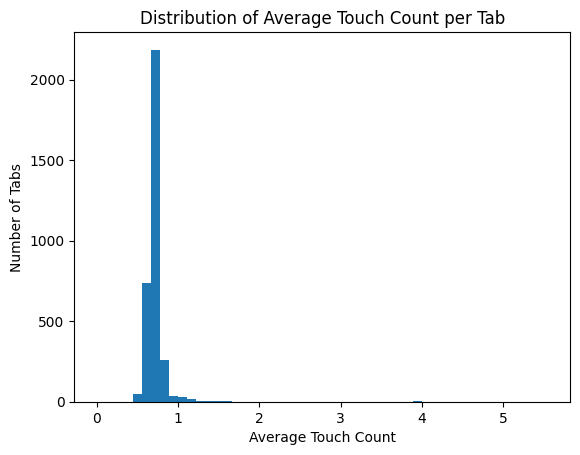

In [29]:
avg_touch_count_per_tab.plot(kind='hist', bins=50, title="Distribution of Average Touch Count per Tab", xlabel='Average Touch Count', ylabel='Number of Tabs')

<Axes: title={'center': 'Distribution of Mouse Position Spread per Tab'}, xlabel='Mouse Position Spread', ylabel='Number of Tabs'>

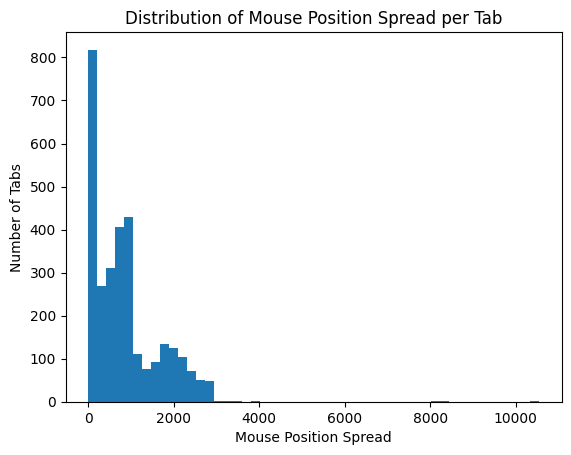

In [30]:
mouse_position_spread.plot(kind='hist', bins=50, title="Distribution of Mouse Position Spread per Tab", xlabel='Mouse Position Spread', ylabel='Number of Tabs')

### Touch & Mouse Events Results

#### Touch Events
- **Total touch events**: ~737k (the largest single category of user interactions).  
- **Average touch count per tab**: ~0.71 touches.  
- **Distribution**:  
  - Most tabs cluster tightly around 0.66–0.72.  
  - A few outliers exist (up to **5.5 touches**), which may reflect multi-touch gestures or logging anomalies.  
- **Insight**: The very narrow distribution suggests touches are logged in a consistent way, making deviations (very high or very low values) potential indicators of abnormal sessions.

#### Mouse Events
- **Total mouse events**: ~352k.  
- **Position spread per tab (variation in X/Y coordinates)**:  
  - **Median spread**: ~704 pixels.  
  - **25th–75th percentile**: ~156 – 1,113 pixels.  
  - **Outliers**: spreads above **10,000 pixels** are possible, though these may reflect large screens or abnormal movements.  
- **Insight**: Humans typically interact across varied screen areas.  
  - Tabs with **zero spread** suggest fixed-position clicks (possibly automated).  
  - Tabs with **excessively large spread** may indicate unusual or scripted behaviors.

#### Click Events
- **Clicks**: ~ 51k total (~3% of all events).  
- **Note**: Although less frequent, clicks are critical for bot detection: bots may generate many clicks without realistic accompanying scrolls, touches, or mouse moves.


### Rare & Contextual Events

Beyond scrolling, clicking, and touch/mouse movements, the dataset also includes **system- or context-related events** such as:

- **RESIZE** → when the browser window or viewport is resized.  
- **VISIBILITY_CHANGE** → when a tab is hidden or made visible (tab switching).  
- **ERROR** → logging of failed actions or unexpected behavior.  
- **INPUT / KEY events** → user typing or form inputs.  
- **Navigation events** → `PUSH_STATE`, `POP_STATE`, `REPLACE_STATE`.  

#### Why it matters
- Humans rarely **resize** their browsers repeatedly or trigger large numbers of **errors**.  
- **VISIBILITY changes** (tab switching) are common in human behavior but may be missing in scripted sessions.  
- **Errors and failed element selectors** can indicate **bots interacting with page structures incorrectly**.  
- These events may not dominate counts but serve as **qualitative red flags** for automation.


In [31]:
rare_events = ["RESIZE", "VISIBILITY_CHANGE", "ERROR", "INPUT", "PUSH_STATE", "POP_STATE", "REPLACE_STATE"]
rare_counts = events_df[events_df['event_type'].isin(rare_events)]['event_type'].value_counts()

rare_pic = (rare_counts / len(events_df)) * 100

rare_dist = pd.DataFrame({
    "count": rare_counts,
    "percentage": rare_pic
})

rare_dist

,count,percentage
event_type,,
RESIZE,51938,3.218919
ERROR,32052,1.986461
VISIBILITY_CHANGE,16956,1.050868
INPUT,16638,1.031160
PUSH_STATE,12150,0.753011
REPLACE_STATE,3594,0.222742
POP_STATE,3203,0.198510


<Axes: title={'center': 'Distribution of Rare Events'}, xlabel='Event Type', ylabel='Number of Events'>

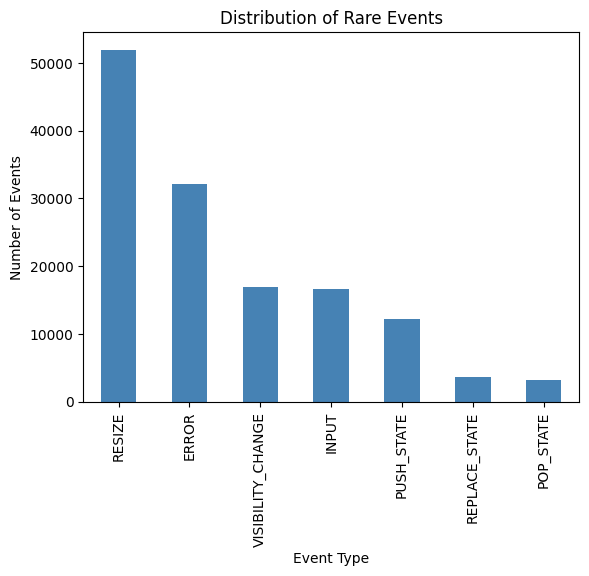

In [32]:
rare_counts.plot(kind='bar', xlabel='Event Type', ylabel='Number of Events', title='Distribution of Rare Events', color='steelblue')

### Rare & Contextual Events Results

From the total **1,613,523 events**, the less common categories make up only a small share:

- **RESIZE** → 51,938 events (~3.2%)  
- **ERROR** → 32,052 events (~2.0%)  
- **VISIBILITY_CHANGE** → 16,956 events (~1.1%)  
- **INPUT** → 16,638 events (~1.0%)  
- **Navigation events** (`PUSH_STATE`, `POP_STATE`, `REPLACE_STATE`) together <1.2%  

#### Key takeaways
- Most sessions contain almost no resizes, errors, or navigation calls.  
- A few sessions with **many resizes or errors** are unusual and may be scripted.  
- **Missing INPUT or VISIBILITY_CHANGE** in long, active sessions could also be suspicious.  

### Events vs. Session Duration

To start connecting features, we will examine how the number of events relates to the session duration.  
- Humans typically generate a balanced number of events over time.  
- Bots may generate *too many events in short sessions* or *very few events in long sessions*.  

We will compute **events per minute** for each tab and visualize the distribution to spot unusual behavior.


In [33]:
events_sorted_df = events_df.groupby('tbid', group_keys=False).apply(
    lambda x: x.sort_values('happened_at')
)

session_length_min = events_df.groupby('tbid').apply(
    lambda x: (x['happened_at'].max() - x['happened_at'].min()).total_seconds() / 60
).rename('session_length_min')

events_count = events_sorted_df.groupby('tbid')['event_type'].count().rename('event_count')

tab_features = pd.concat([session_length_min, events_count], axis=1).reset_index()
tab_features['session_length_min'] = tab_features['session_length_min'].replace(0, 1e-6)

tab_features['events_per_min'] = tab_features['event_count'] / tab_features['session_length_min']

/tmp/ipython-input-2855740471.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  events_sorted_df = events_df.groupby('tbid', group_keys=False).apply(
/tmp/ipython-input-2855740471.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  session_length_min = events_df.groupby('tbid').apply(


In [34]:
tab_features['events_per_min'].describe()

,events_per_min
count,4.498000e+03
mean,3.641275e+04
std,2.688479e+05
min,6.137353e-03
25%,5.389834e+01
50%,1.194706e+02
75%,2.010502e+02
max,4.000000e+06


<Axes: title={'center': 'Distribution of Events per Minute'}, xlabel='Events per Minute', ylabel='Number of Tabs'>

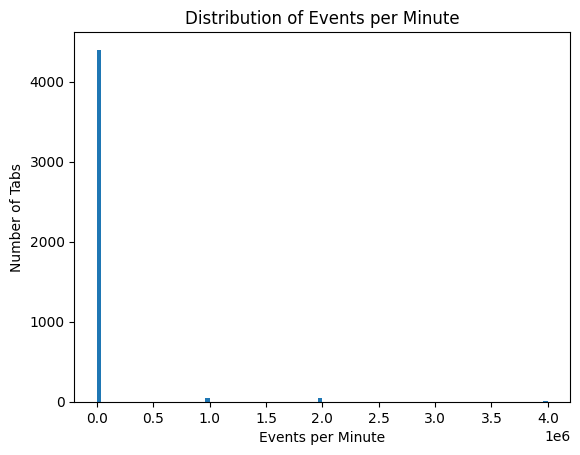

In [35]:
tab_features['events_per_min'].plot(kind='hist', bins=100, title="Distribution of Events per Minute", xlabel='Events per Minute', ylabel='Number of Tabs')

<Axes: title={'center': 'Events vs. Session Duration'}, xlabel='Session Duration (min)', ylabel='Number of Events'>

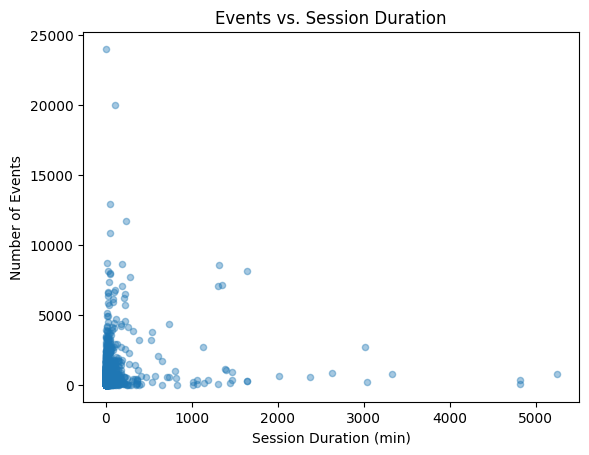

In [36]:
tab_features.plot(kind='scatter', x = 'session_length_min', y = 'event_count', title="Events vs. Session Duration", xlabel='Session Duration (min)', ylabel='Number of Events', alpha=0.4)

#### 🔎 Insights: Events vs. Session Duration

- Most sessions fall in a reasonable band: **50–200 events per minute**.  
- However, there are **extreme outliers**:
  - Tabs with **tens of thousands of events per minute** (max ≈ 4M).  
  - Sessions lasting hours but with very few events.  
- These patterns are inconsistent with human browsing behavior and strongly suggest **bot automation**.


### Event Entropy & Dominance

Next, we analyze the diversity of user actions within each tab.  
- **Humans** usually produce a mix of events (scrolls, clicks, touches, mouse moves).  
- **Bots** often repeat one event type excessively (e.g., only SCROLL or only TOUCH_MOVE).  

We will compute:
- **Event Entropy**: Shannon entropy of event types per tab (higher = more diverse).  
- **Dominant Event Ratio**: Share of the most frequent event type in a tab.  

These features help distinguish natural browsing from repetitive automated behavior.


In [37]:
import numpy as np
from scipy.stats import entropy

event_type_counts = events_df.groupby(['tbid', 'event_type']).size().reset_index(name='count')

def compute_entropy_and_dominance(group):
  counts = group['count'].values
  probs = counts / sum(counts)
  ent = entropy(probs, base=2)
  dominant_ratio = counts.max() / counts.sum()
  return pd.Series([ent, dominant_ratio], index=['event_entropy', 'dominant_ratio'])

event_entropy_dominance = event_type_counts.groupby('tbid').apply(compute_entropy_and_dominance).reset_index()

tab_features_with_entropy = pd.merge(tab_features, event_entropy_dominance, on='tbid', how='left')
print("Event Entropy Summary:")
display(tab_features_with_entropy['event_entropy'].describe())

print("Event Entropy Dominance Summary:")
display(tab_features_with_entropy['dominant_ratio'].describe())

Event Entropy Summary:


/tmp/ipython-input-2363046803.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  event_entropy_dominance = event_type_counts.groupby('tbid').apply(compute_entropy_and_dominance).reset_index()


,event_entropy
count,4498.000000
mean,2.012382
std,0.746705
min,0.000000
25%,1.610420
50%,2.014190
75%,2.500210
max,3.682401


Event Entropy Dominance Summary:


,dominant_ratio
count,4498.000000
mean,0.478566
std,0.174073
min,0.138201
25%,0.368062
50%,0.450000
75%,0.540127
max,1.000000


<Axes: title={'center': 'Distribution of Event Entropy'}, xlabel='Event Entropy', ylabel='Number of Tabs'>

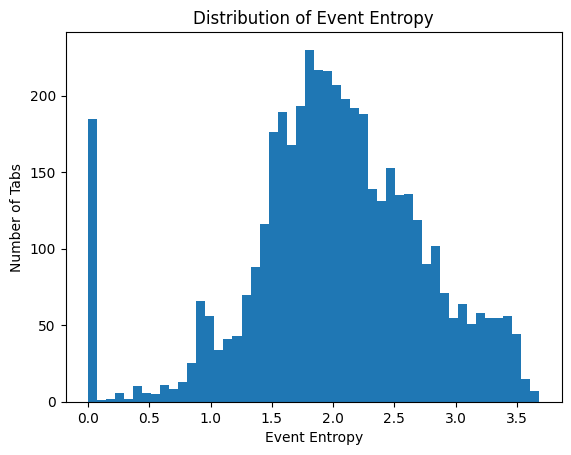

In [38]:
tab_features_with_entropy['event_entropy'].plot(kind='hist', bins=50, title="Distribution of Event Entropy", xlabel='Event Entropy', ylabel='Number of Tabs')

<Axes: title={'center': 'Distribution of Dominant Event Ratio'}, xlabel='Dominant Event Ratio', ylabel='Number of Tabs'>

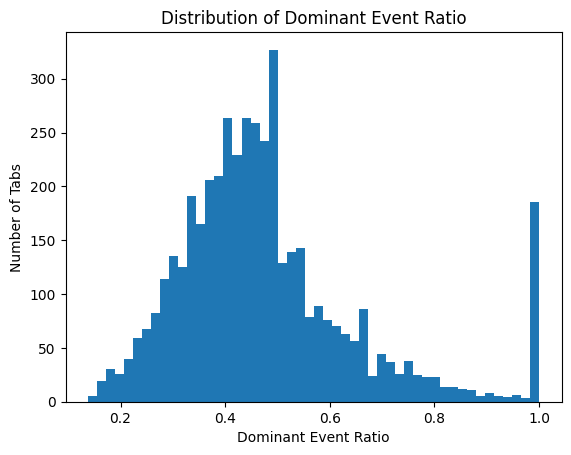

In [39]:
tab_features_with_entropy['dominant_ratio'].plot(kind='hist', bins=50, title="Distribution of Dominant Event Ratio", xlabel='Dominant Event Ratio', ylabel='Number of Tabs')
#

#### 🔎 Insights: Event Entropy & Dominance

- **Entropy (diversity of actions):**
  - Median ≈ 2.0 bits → most sessions show a balanced mix of event types.
  - Outliers: some tabs have **entropy = 0** → only one type of event (e.g., only SCROLL or only TOUCH). This is strongly bot-like.

- **Dominant Event Ratio:**
  - Median ≈ 0.45 → in typical sessions, no single event dominates.
  - Upper outliers reach **1.0** → all events are of the same type, again a strong anomaly.
  - Bots are expected to have a **low entropy + high dominant ratio** signature.

These features effectively separate **human-like diverse browsing** from **repetitive automated behavior**.


### Device Type vs. Event Type Consistency

Human interaction patterns should align with device type:
- **Mobile/Tablet** → mostly touch + scroll events, almost no mouse events.
- **Desktop** → mostly mouse + keyboard events, almost no touch events.
- **Unknown devices** → high risk of automation.

We will compute, for each tab:
- Proportion of `TOUCH_*` events.
- Proportion of `MOUSE_*` events.
- Proportion of `KEY_*` events.

Then we can flag mismatches, e.g.:
- A "mobile" device generating only mouse moves.
- A "desktop" device generating mostly touch events.


In [40]:
df['device'] = df['device'].fillna('unknown')

events_with_device = events_df.merge(df[['tbid', 'device']], on='tbid', how='left')

def categorize_event(event):
  if event.startswith('TOUCH'):
    return 'TOUCH'
  elif event.startswith('MOUSE'):
    return 'MOUSE'
  elif event.startswith('KEY'):
    return 'KEY'
  else:
    return 'OTHER'

events_with_device['event_group'] = events_with_device['event_type'].apply(categorize_event)

event_mix = events_with_device.groupby(['tbid', 'event_group']).size().reset_index(name='count')
event_totals = event_mix.groupby('tbid')['count'].sum().reset_index(name='total')
event_mix = event_mix.merge(event_totals, on='tbid')
event_mix['proportion'] = event_mix['count'] / event_mix['total']

event_mix_wide = event_mix.pivot(index='tbid', columns='event_group', values='proportion').fillna(0).reset_index()

tab_event_device = pd.merge(df[['tbid', 'device']], event_mix_wide, on='tbid', how='left')
tab_event_device.head()

,tbid,device,KEY,MOUSE,OTHER,TOUCH
0,29f79081-1057-43b2-b22d-8260ff55d80e,m,0.0,0.080645,0.295699,0.623656
1,ff6ad41b-5f8f-4ba7-a30d-d27625fae06d,m,0.0,0.031579,0.249123,0.719298
2,2020b325-ff27-4003-b0ad-75bf2cd60798,m,0.0,0.000000,0.275862,0.724138
3,428b1d7c-3e38-4339-90a4-576d9be1d462,m,0.0,0.017143,0.262857,0.720000
4,144e269f-5e79-4fec-b5e6-b56b0fd68e81,m,0.0,0.104000,0.352000,0.544000


/tmp/ipython-input-304446891.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.loc[g['proportion'].idxmax(), 'event_group'])


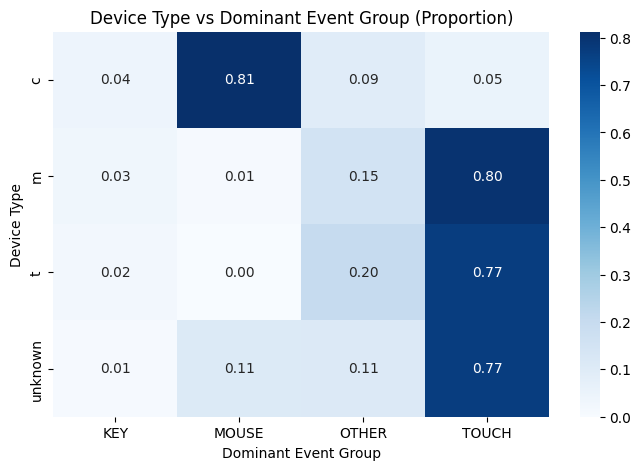

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

dominant_event_group = (
    event_mix.groupby('tbid')
    .apply(lambda g: g.loc[g['proportion'].idxmax(), 'event_group'])
    .reset_index(name='dominant_event_group')
)

device_vs_event = df[['tbid', 'device']].merge(dominant_event_group, on='tbid')

crosstab = pd.crosstab(device_vs_event['device'], device_vs_event['dominant_event_group'], normalize='index')

plt.figure(figsize=(8,5))
sns.heatmap(crosstab, annot=True, fmt=".2f", cmap="Blues")
plt.title("Device Type vs Dominant Event Group (Proportion)")
plt.xlabel("Dominant Event Group")
plt.ylabel("Device Type")
plt.show()

#### 🔎 Insights: Device Type vs. Dominant Event Group

- **Desktop (c)** → 81% of tabs are dominated by `MOUSE` events, which is expected. A small fraction show `TOUCH` dominance (~5%), which is inconsistent and potentially automated.  
- **Mobile (m)** → 80% of tabs are `TOUCH`-dominant, but ~15% are classified as `OTHER`, which is unusual for genuine mobile sessions.  
- **Tablet (t)** → 77% are `TOUCH`-dominant, but 20% fall into `OTHER`, suggesting possible automation or hybrid emulation.  
- **Unknown devices** → 77% also show `TOUCH` dominance, which is suspicious given the lack of clear device type.  

👉 Overall: While most sessions align with expectations, the **mismatched cases** (desktop with touch dominance, mobile/tablet with non-touch dominance, and “unknown” devices) represent strong candidates for **bot-like or emulated activity**.


### Examples of Suspicious Tabs

In [42]:
def flag_suspicious(row):
    if row['device'] == 'c' and row['dominant_event_group'] == 'TOUCH':
        return True
    if row['device'] in ['m', 't'] and row['dominant_event_group'] == 'MOUSE':
        return True
    if row['device'] == 'Unknown':
        return True
    return False

device_vs_event['suspicious'] = device_vs_event.apply(flag_suspicious, axis=1)

suspicious_tabs = (
    device_vs_event[device_vs_event['suspicious']]
    .merge(tab_features_with_entropy[['tbid', 'event_entropy', 'events_per_min']], on='tbid', how='left')
)

suspicious_tabs[['tbid', 'device', 'dominant_event_group', 'event_entropy', 'events_per_min']] \
    .sort_values('events_per_min', ascending=False) \
    .head(10)


,tbid,device,dominant_event_group,event_entropy,events_per_min
101,ad6cb2db-15b3-4bda-b107-ef085cb16048,m,MOUSE,2.251629,49655.172414
116,ad6cb2db-15b3-4bda-b107-ef085cb16048,m,MOUSE,2.251629,49655.172414
115,ad6cb2db-15b3-4bda-b107-ef085cb16048,m,MOUSE,2.251629,49655.172414
102,ad6cb2db-15b3-4bda-b107-ef085cb16048,m,MOUSE,2.251629,49655.172414
60,8ef163d1-603b-4b50-ad40-7b2b7ebc94ab,m,MOUSE,2.251629,6545.454545
105,f79328b1-f29c-44c7-8959-69c1af2ce4d1,m,MOUSE,2.521641,3962.264151
104,f79328b1-f29c-44c7-8959-69c1af2ce4d1,m,MOUSE,2.521641,3962.264151
52,7b7f7a18-494b-4ccf-93c1-d675dcf00ae9,m,MOUSE,2.251629,3711.340206
100,a889595d-3bbd-4df9-a7d3-d99dc9a503e0,m,MOUSE,2.521641,1696.969697
108,a889595d-3bbd-4df9-a7d3-d99dc9a503e0,m,MOUSE,2.521641,1696.969697


#### 🔎 Insights: Suspicious Tab Examples

The sample above highlights **mobile devices (`m`) whose dominant event group is `MOUSE`**, which is inconsistent with expected human behavior:

- Several tabs (e.g., `ad6cb2db-15b3...`) show **extremely high activity rates** — ~50k events per minute.  
- Despite high activity, their **event entropy remains moderate (~2.25 bits)**, suggesting repetitive patterns.  
- Other tabs (e.g., `7b7f7a18-494b...`, `a889595d-3bbd...`) also show **unrealistically high events/minute** values in the thousands.  

👉 These mismatches strongly suggest **automated scripts or emulated devices** generating mouse events under a mobile device label.  
They illustrate how **device–event inconsistencies combined with behavioral metrics (entropy + speed)** can reveal potential bots.


## Feature Engineering

Based on our EDA, we now design features that capture unusual or bot-like behaviors.
The goal is to transform raw tab- and event-level data into a structured feature set
that can be used for anomaly detection or classification.

We will group features into logical categories:

1. **Activity & Timing Features**
   - Session length (minutes)
   - Event count
   - Events per minute
   - Mean / std of inter-event gap (regularity vs. randomness)

2. **Event Diversity Features**
   - Event entropy (Shannon entropy of event types)
   - Dominant event ratio (share of the most frequent event)

3. **Scroll Behavior Features**
   - Max scroll depth normalized by viewport height
   - Scroll velocity (avg, std)
   - Scroll depth variance

4. **Spatial Interaction Features**
   - Mouse X/Y range, Touch X/Y range
   - Click spread (difference between max & min coordinates)
   - Flags for zero-spread clicks or extreme sweeps

5. **Rare Event Ratios**
   - Resize rate (resizes per session minute)
   - Error rate (errors per 100 events)
   - Visibility change rate
   - Input rate

6. **Device & Environment Features**
   - Device type (mobile, desktop, tablet, unknown)
   - Screen/viewport ratio
   - Tabs per user
   - Device–event mismatch flag (e.g., mobile with mouse-dominant events)

---

Each of these engineered features is motivated by human vs. bot differences:

- **Humans** show balanced, diverse, irregular patterns with contextually consistent device-event relationships.
- **Bots** show extreme counts, regular timing, repetitive events, impossible environment settings, or mismatches.

Next, we will implement these feature groups step by step and build a final
**tab-level feature matrix** ready for anomaly detection models.


### Feature Engineering Blueprint

The table below summarizes the candidate features, grouped by category,
with their definitions and rationale for detecting unusual (bot-like) behavior.

| Feature Group              | Feature Name                  | Definition / Calculation                                   | Why it Matters |
|-----------------------------|-------------------------------|------------------------------------------------------------|----------------|
| **Activity & Timing**       | `session_length_min`          | Duration of tab session in minutes                         | Extremely short/long sessions are suspicious |
|                             | `event_count`                 | Total events in the tab                                    | Bots often generate thousands of events |
|                             | `events_per_minute`           | Event count / session length                               | Extreme activity rates flag automation |
|                             | `mean_inter_event_gap`        | Avg time gap between events                                | Humans are irregular; bots may have fixed intervals |
|                             | `std_inter_event_gap`         | Variability of inter-event gaps                            | Low std = repetitive patterns |
| **Event Diversity**         | `event_entropy`               | Shannon entropy of event type distribution                 | Low entropy = repetitive actions |
|                             | `dominant_event_ratio`        | Share of most frequent event type                          | High ratio = single-type automation |
| **Scroll Behavior**         | `normalized_scroll_depth`     | Max scroll depth / viewport height                         | Bots may scroll unnaturally deep |
|                             | `scroll_velocity_mean`        | Avg scroll speed (Δdepth / Δtime)                         | Extreme speeds unlikely for humans |
|                             | `scroll_velocity_std`         | Variability of scroll speed                                | Humans vary, bots are regular |
| **Spatial Interaction**     | `mouse_x_range`, `mouse_y_range` | Range of X/Y positions for mouse events                 | Zero range = fixed click point |
|                             | `touch_x_range`, `touch_y_range` | Range of X/Y positions for touch events                 | Large sweeps may indicate scripts |
|                             | `click_spread`                | Max–min of click coordinates                               | Helps detect fixed vs random clicking |
| **Rare Event Ratios**       | `resize_rate`                 | Resizes per session minute                                 | Bots/test scripts often resize repeatedly |
|                             | `error_rate`                  | Errors / total events                                      | Bots hit missing selectors; humans rarely do |
|                             | `visibility_change_rate`      | Visibility changes / total events                          | No tab switches in long sessions = suspicious |
|                             | `input_rate`                  | Input events / total events                                | Absence of input in long activity = automation |
| **Device & Environment**    | `screen_viewport_ratio`       | viewport_area / screen_area                                | Extreme ratios = invalid setups |
|                             | `tabs_per_user`               | Number of tabs opened by same user                        | High counts suggest scripted browsing |
|                             | `device_event_mismatch`       | Flag if device type inconsistent with dominant event group | Mobile with mouse, desktop with touch = bot |


### Feature Engineering — Group 1: Activity & Timing

We’ll engineer session-level activity features that capture **tempo and intensity**:
- `session_length_min`, `event_count`, `events_per_minute`
- Inter-event gap stats: `gap_mean_s`, `gap_std_s`, `gap_median_s`, `gap_p95_s`
- A helpful flag: `instant_session` when all events share the same timestamp

These quantify how *fast* and *regular* interactions are — bots tend to be **extreme and/or highly regular**.


In [43]:
required_cols = {'tbid', 'happened_at', 'event_type'}
missing_cols = required_cols - set(events_df.columns)
assert not missing_cols, f"events_df missing required columns: {missing_cols}"
assert np.issubdtype(events_df['happened_at'].dtype, np.datetime64), "happened_at must be datetime"

events_sorted = (
    events_df
    .sort_values(['tbid', 'happened_at'])
    .reset_index(drop=True)
)

session_span = (
    events_sorted.groupby('tbid', as_index=False)
    .agg(
        first_time = ('happened_at', 'min'),
        last_time = ('happened_at', 'max'),
        event_count = ('event_type', 'count')
    )
)
session_span['session_length_min'] = (session_span['last_time'] - session_span['first_time']).dt.total_seconds() / 60

def gap_stats(group):
  gaps = group['happened_at'].diff().dt.total_seconds().dropna()
  if gaps.empty:
    return pd.Series([np.nan, np.nan, np.nan, np.nan], index=['gap_mean_s', 'gap_std_s', 'gap_median_s', 'gap_p95_s'])
  return pd.Series([gaps.mean(), gaps.std(ddof=1) if len(gaps) > 1 else 0, gaps.median(), np.percentile(gaps, 95)], index=['gap_mean_s', 'gap_std_s', 'gap_median_s', 'gap_p95_s'])

gap_features = (
    events_sorted.groupby('tbid', as_index=False)
    .apply(gap_stats)
    .reset_index()
)

activity_features = (
    session_span
    .merge(gap_features, on='tbid', how='left')
    .copy()
)

activity_features['instant_session'] = (activity_features['session_length_min'] == 0)

safe_minutes = activity_features['session_length_min'].replace(0, 1e-6)
activity_features['events_per_minute'] = activity_features['event_count'] / safe_minutes

activity_features = activity_features[[
    'tbid',
    'event_count',
    'session_length_min',
    'events_per_minute',
    'gap_mean_s','gap_std_s','gap_median_s','gap_p95_s',
    'instant_session'
]]

engineered_features = activity_features
display(engineered_features[['event_count','session_length_min','events_per_minute','gap_mean_s','gap_std_s','instant_session']].describe())

/tmp/ipython-input-3718683560.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(gap_stats)


,event_count,session_length_min,events_per_minute,gap_mean_s,gap_std_s
count,4498.000000,4498.000000,4.498000e+03,4455.000000,4455.000000
mean,358.720098,24.866170,3.641275e+04,18.551819,93.115975
std,928.417877,190.443115,2.688479e+05,301.885400,1022.153253
min,1.000000,0.000000,6.137353e-03,0.000000,0.000000
25%,36.000000,0.300221,5.389834e+01,0.308636,0.616290
50%,99.000000,1.035458,1.194706e+02,0.519483,1.299300
75%,304.000000,4.714112,2.010502e+02,1.171489,5.222302
max,24001.000000,5243.179983,4.000000e+06,13034.935667,45159.017550


### Feature Engineering — Group 2: Event Diversity

Next, we quantify the diversity of event types within each tab session:
- `event_entropy`: Shannon entropy of the event distribution.
- `dominant_event_ratio`: the share of the most frequent event type.

**Why it matters:**
- Humans usually generate diverse actions (scroll, move, click, input).
- Bots tend to repeat a single event type (e.g., scroll only), leading to **low entropy** and **high dominance**.


In [44]:
event_type_counts = events_df.groupby(['tbid', 'event_type']).size().reset_index(name='count')

def diversity_stats(group):
  counts = group['count'].values
  probs = counts / counts.sum()
  ent = entropy(probs, base=2)
  return pd.Series([ent, counts.max() / counts.sum()], index=['event_entropy', 'dominant_event_ratio'])

diversity_features =(
    event_type_counts.groupby('tbid')
    .apply(diversity_stats)
    .reset_index()
)

engineered_features = engineered_features.merge(diversity_features, on='tbid', how='left')
display(engineered_features[['event_entropy','dominant_event_ratio']].describe())

/tmp/ipython-input-2524866894.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(diversity_stats)


,event_entropy,dominant_event_ratio
count,4498.000000,4498.000000
mean,2.012382,0.478566
std,0.746705,0.174073
min,0.000000,0.138201
25%,1.610420,0.368062
50%,2.014190,0.450000
75%,2.500210,0.540127
max,3.682401,1.000000


### Feature Engineering — Group 3: Scroll Behavior

Scrolling patterns can reveal clear differences between humans and bots:

- **Humans**: scroll in bursts, with natural variation in depth and speed.  
- **Bots**: scroll at extreme depths, uniform speeds, or unrealistic velocities.  

We will compute:
- `max_scroll_depth`: maximum absolute scroll depth observed.
- `normalized_scroll_depth`: max scroll depth divided by viewport height (relative depth).
- `scroll_velocity_mean`: average scroll speed (Δdepth / Δtime).
- `scroll_velocity_std`: variation in scroll speed.

**Why it matters:**
Bots often scroll *too deep, too fast, or too consistently*, while humans are more irregular.


In [45]:
scrolls = events_df[events_df['event_type'] == 'SCROLL'].copy()
scrolls = scrolls.sort_values(['tbid', 'happened_at'])

scroll_depths = scrolls.groupby('tbid')['scroll_depth'].max().reset_index(name='max_scroll_depth')

scroll_depths = scroll_depths.merge(
    df[['tbid', 'viewport.height']], on='tbid', how='left'
)

scroll_depths['normalized_scroll_depth'] = scroll_depths['max_scroll_depth'] / scroll_depths['viewport.height']

def scroll_velocity_stats(group):
  if len(group) < 2:
    return pd.Series({'scroll_velocity_mean': np.nan, 'scroll_velocity_std': np.nan})
  deltas = group['scroll_depth'].diff().fillna(0)
  times = group['happened_at'].diff().dt.total_seconds().fillna(0)
  velocities = deltas / times.replace(0, np.nan)
  return pd.Series({'scroll_velocity_mean': velocities.mean(skipna=True), 'scroll_velocity_std': velocities.std(ddof=1, skipna=True)})

scroll_velocity = (
    scrolls.groupby('tbid')
    .apply(scroll_velocity_stats)
    .reset_index()
)

scroll_features = (
    scroll_depths
    .merge(scroll_velocity, on='tbid', how='left')
)

engineered_features = engineered_features.merge(scroll_features, on='tbid', how='left')
display(engineered_features[['max_scroll_depth','normalized_scroll_depth','scroll_velocity_mean','scroll_velocity_std']].describe())

/tmp/ipython-input-2206505096.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(scroll_velocity_stats)


,max_scroll_depth,normalized_scroll_depth,scroll_velocity_mean,scroll_velocity_std
count,5711.000000,5711.000000,5371.000000,4993.000000
mean,5225.184663,6.989770,40.613561,389.831969
std,10255.198608,13.612357,182.797883,476.581829
min,0.000000,0.000000,-2335.678473,0.000000
25%,837.000000,1.133206,-24.719935,148.183889
50%,2291.000000,3.033557,23.066502,263.537836
75%,5521.000000,7.313120,103.693262,464.210968
max,161172.000000,242.728916,3731.997243,7045.784387


#### Visualizing Scroll Behavior

To better understand scroll patterns across devices, we plot the distribution of **normalized scroll depth**
(max depth divided by viewport height).

- **Humans** usually scroll 1–10 viewport heights.  
- **Bots** may scroll unrealistically deep (hundreds of viewport heights).  


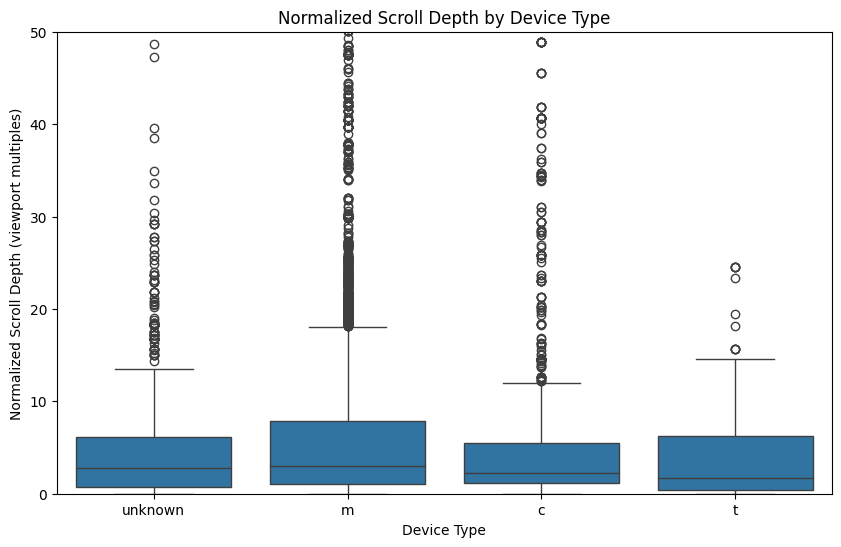

In [46]:
plt.figure(figsize=(10,6))
sns.boxplot(
    data=engineered_features.merge(df[['tbid','device']], on='tbid', how='left'),
    x='device',
    y='normalized_scroll_depth'
)
plt.ylim(0, 50)  # zoom in; extreme outliers distort the plot
plt.title("Normalized Scroll Depth by Device Type")
plt.xlabel("Device Type")
plt.ylabel("Normalized Scroll Depth (viewport multiples)")
plt.show()


#### 🔎 Insights: Scroll Behavior

- Most sessions fall below **10× viewport height**, consistent with human behavior.  
- Outliers reach **200+ viewport heights**, far beyond human plausibility → strong automation signal.  
- Distribution is fairly consistent across devices, but suspicious outliers appear in **all device categories**.  

👉 Extreme normalized scroll depths and **very high/very stable scroll velocities** are strong candidates for bot detection.


#### Scroll Velocity Patterns

We now examine the relationship between **average scroll speed** and its **variability**.  
- **Humans**: scroll speeds vary naturally → moderate mean, moderate-to-high std.  
- **Bots**: may scroll at highly consistent speeds → high mean but **very low std**.  


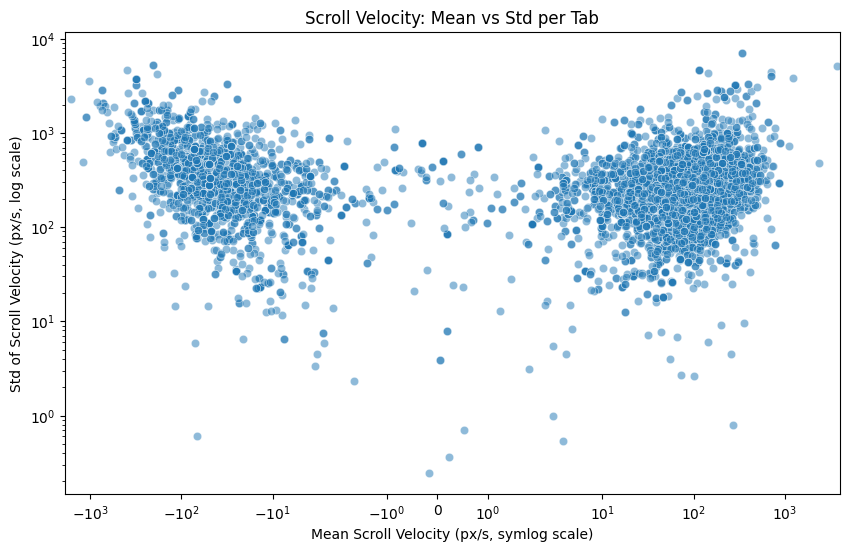

In [47]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=engineered_features,
    x='scroll_velocity_mean',
    y='scroll_velocity_std',
    alpha=0.5
)
plt.xscale('symlog')  # symmetric log handles negatives + wide range
plt.yscale('log')
plt.title("Scroll Velocity: Mean vs Std per Tab")
plt.xlabel("Mean Scroll Velocity (px/s, symlog scale)")
plt.ylabel("Std of Scroll Velocity (px/s, log scale)")
plt.show()


#### 🔎 Insights: Scroll Velocity (Mean vs Std)

- The plot shows **mean scroll velocity** (x-axis) vs **variability of scroll velocity** (y-axis) per tab.  
- We observe two main clusters:
  - **Right cluster (positive mean velocities)** → natural forward scrolling.  
    - Most points have moderate-to-high variability, consistent with human irregular scrolling.  
  - **Left cluster (negative mean velocities)** → backward scrolling dominates (rare for humans).  
    - Still shows high variability, but this group could include noisy logs or scripted behaviors.  

- **Suspicious patterns:**
  - Points with **very high mean (>1000 px/s)** → unrealistic speeds for human scrolling.  
  - Points with **very low std (<10 px/s) but high mean** → uniform scrolling, strongly bot-like.  
  - A few near **0 mean velocities** with low std → almost no variation, suggesting idle or test sessions.  

👉 This confirms that scroll velocity features help differentiate **natural, irregular human scrolling** from **scripted, uniform bot activity**.


### Feature Engineering — Group 4: Spatial Interaction Features

Human interactions are spatially diverse — people move the mouse or tap across different
parts of the screen. Bots, on the other hand, often show:

- **Zero spread** → fixed-position clicks/touches at the exact same coordinates.
- **Excessive spread** → scripted sweeps covering the entire page.

We will compute:
- `mouse_x_range`, `mouse_y_range`: horizontal & vertical spread of mouse events.
- `touch_x_range`, `touch_y_range`: spread of touch events.
- `click_spread`: combined spread of click coordinates.

**Why it matters:**
Spatial consistency (very low spread) or uniform coverage (very high spread) are both strong
indicators of automation.


In [48]:
mouse_events = events_df[events_df['event_type'].str.startswith("MOUSE")].copy()
mouse_spread = (
    mouse_events.groupby('tbid')
    .agg(
        mouse_x_range=('position_x', lambda x: x.max() - x.min() if x.notna().any() else np.nan),
        mouse_y_range=('position_y', lambda x: x.max() - x.min() if x.notna().any() else np.nan)
    )
    .reset_index()
)

touch_events = events_df[events_df['event_type'].str.startswith("TOUCH")].copy()
touch_spread = (
    touch_events.groupby('tbid')
    .agg(
        touch_x_range=('position_x', lambda x: x.max() - x.min() if x.notna().any() else np.nan),
        touch_y_range=('position_y', lambda x: x.max() - x.min() if x.notna().any() else np.nan)
    )
    .reset_index()
)

click_events = events_df[events_df['event_type'].isin(["CLICK","MOUSE_DOWN","MOUSE_UP"])].copy()
click_spread = (
    click_events.groupby('tbid')
    .agg(
        click_spread=('position_x', lambda x: x.max() - x.min() if x.notna().any() else np.nan)
    )
    .reset_index()
)

spatial_features = mouse_spread.merge(touch_spread, on='tbid', how='outer')
spatial_features = spatial_features.merge(click_spread, on='tbid', how='outer')
engineered_features = engineered_features.merge(spatial_features, on='tbid', how='left')

display(engineered_features[['mouse_x_range','mouse_y_range','touch_x_range','touch_y_range','click_spread']].describe())

,mouse_x_range,mouse_y_range,touch_x_range,touch_y_range,click_spread
count,4349.000000,4349.000000,4688.000000,4688.000000,4084.000000
mean,463.161646,405.923661,217.240957,421.558492,361.984819
std,540.880003,378.171129,163.875733,556.841387,445.378509
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,64.000000,113.000000,82.000000,214.593292,18.000000
50%,273.000000,434.000000,213.000000,383.262177,241.000000
75%,641.000000,623.000000,323.000000,570.909065,350.000000
max,2806.000000,10266.000000,1448.000072,13861.000000,2534.000000


#### 🔎 Insights: Spatial Interaction Features

- **Typical human ranges**:
  - Mouse spread: usually a few hundred pixels (X ~270 median, Y ~430 median).
  - Touch spread: also in the hundreds, consistent with tapping/swiping across part of the screen.
  - Click spread: ~240 median, suggesting natural variation in click positions.

- **Suspicious cases**:
  - **Zero spread** (min = 0) → repeated clicks/taps at a fixed point → very likely automated.
  - **Extreme spread** (max up to 10k–13k pixels) → much larger than typical viewport size → indicates automation or corrupted logs.

👉 Spatial interaction metrics can highlight both *rigid, repetitive bots* (zero spread) and *scripted sweeps* (excessive spread).


#### Flagging Suspicious Spatial Patterns

To make these features more interpretable, we create simple flags:

- **Zero-spread flag** → all clicks/touches/mouse at the exact same point.  
- **Extreme-spread flag** → spread far beyond realistic screen/viewport size.  

These binary indicators make it easier to spot **rigid automated clicks** or **scripted sweeps**.


In [49]:
spatial_with_screen = engineered_features.merge(
    df[['tbid', 'screen.width', 'screen.height']], on='tbid', how='left'
)

#Zero Spread Flags
spatial_with_screen['zero_mouse_spread'] = (spatial_with_screen['mouse_x_range'] == 0) & (spatial_with_screen['mouse_y_range'] == 0)
spatial_with_screen['zero_touch_spread'] = (spatial_with_screen['touch_x_range'] == 0) & (spatial_with_screen['touch_y_range'] == 0)
spatial_with_screen['zero_click_spread'] = (spatial_with_screen['click_spread'] == 0)

# Extreme Spread Flags
spatial_with_screen['extreme_mouse_spread'] = (
    (spatial_with_screen['mouse_x_range'] > 2 * spatial_with_screen['screen.width']) |
    (spatial_with_screen['mouse_y_range'] > 2 * spatial_with_screen['screen.height'])
)

spatial_with_screen['extreme_touch_spread'] = (
    (spatial_with_screen['touch_x_range'] > 2 * spatial_with_screen['screen.width']) |
    (spatial_with_screen['touch_y_range'] > 2 * spatial_with_screen['screen.height'])
)

spatial_with_screen['extreme_click_spread'] = (
    (spatial_with_screen['click_spread'] > 2 * spatial_with_screen['screen.width']) |
    (spatial_with_screen['click_spread'] > 2 * spatial_with_screen['screen.height'])
)

display(spatial_with_screen[['zero_mouse_spread','zero_touch_spread','zero_click_spread','extreme_mouse_spread','extreme_touch_spread','extreme_click_spread']].describe())

,zero_mouse_spread,zero_touch_spread,zero_click_spread,extreme_mouse_spread,extreme_touch_spread,extreme_click_spread
count,11539,11539,11539,11539,11539,11539
unique,2,2,2,2,2,2
top,False,False,False,False,False,False
freq,10335,11489,10157,11528,11481,11538


In [50]:
engineered_features = spatial_with_screen.copy()

#### Visualizing Spatial Anomaly Flags

To quickly see which types of suspicious spatial behaviors are most common,  
we plot the frequency of zero-spread and extreme-spread flags.


/tmp/ipython-input-317574834.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=flag_counts, x='flag_type', y='count', palette="Set2")


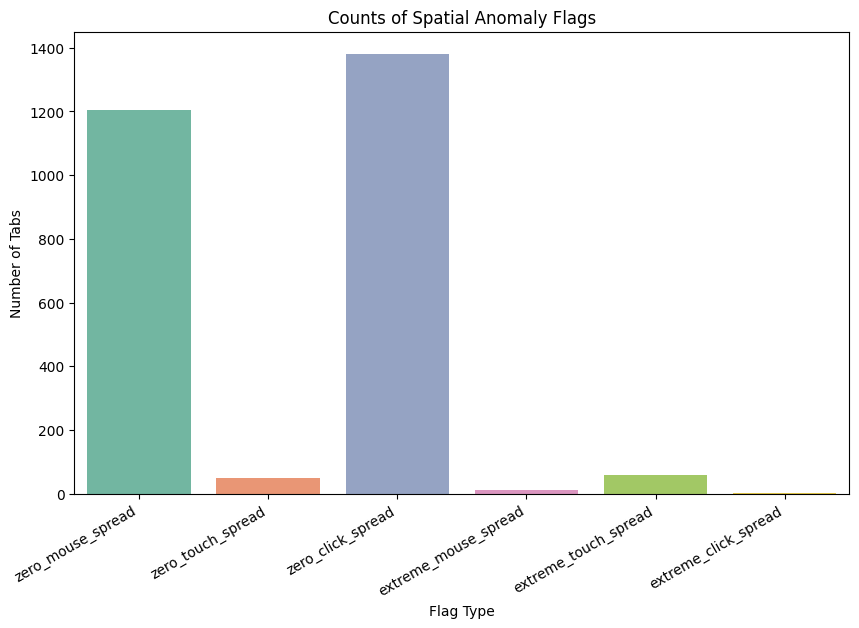

In [51]:
# --- Summarize flags ---
flag_counts = engineered_features[[
    'zero_mouse_spread','zero_touch_spread','zero_click_spread',
    'extreme_mouse_spread','extreme_touch_spread','extreme_click_spread'
]].sum().reset_index()

flag_counts.columns = ['flag_type','count']

# --- Bar plot ---
plt.figure(figsize=(10,6))
sns.barplot(data=flag_counts, x='flag_type', y='count', palette="Set2")
plt.title("Counts of Spatial Anomaly Flags")
plt.ylabel("Number of Tabs")
plt.xlabel("Flag Type")
plt.xticks(rotation=30, ha='right')
plt.show()


### Feature Engineering — Group 5: Rare Event Ratios

Rare events provide strong signals of unusual sessions:

- **RESIZE**: Humans occasionally resize, but high resize frequency suggests automated testing.  
- **ERROR**: Humans rarely trigger element errors, bots often do.  
- **VISIBILITY_CHANGE**: Natural browsing includes tab switches; long active sessions without them may be suspicious.  
- **INPUT**: Lack of typing in event-heavy sessions suggests automation.  

We will compute:
- `resize_rate` = resize events per session minute.  
- `error_rate` = error events per 100 events.  
- `visibility_change_rate` = visibility events per 100 events.  
- `input_rate` = input events per 100 events.  


In [52]:
rare_events = (
    events_df[events_df['event_type'].isin(['RESIZE','ERROR','VISIBILITY_CHANGE','INPUT'])]
    .groupby(['tbid', 'event_type'])
    .size()
    .reset_index(name='count')
)

rare_pivot = rare_events.pivot(index='tbid', columns='event_type', values='count').fillna(0).reset_index()

rare_features = rare_pivot.merge(
    engineered_features[['tbid','event_count','session_length_min']],
    on='tbid',
    how='left'
)

safe_minutes = rare_features['session_length_min'].replace(0, 1e-6)
rare_features['resize_rate'] = rare_features['RESIZE'] / safe_minutes
rare_features['error_rate'] = rare_features['ERROR'] / rare_features['event_count']
rare_features['visibility_change_rate'] = rare_features['VISIBILITY_CHANGE'] / rare_features['event_count']
rare_features['input_rate'] = rare_features['INPUT'] / rare_features['event_count']

rare_features = rare_features[[
    'tbid','resize_rate','error_rate','visibility_change_rate','input_rate'
]]

engineered_features = engineered_features.merge(rare_features, on='tbid', how='left')

display(engineered_features[['resize_rate','error_rate','visibility_change_rate','input_rate']].describe())

,resize_rate,error_rate,visibility_change_rate,input_rate
count,1.177960e+05,117796.000000,117796.000000,117796.000000
mean,8.879391e+01,0.008204,0.052625,0.009090
std,1.201300e+04,0.036538,0.100130,0.012146
min,0.000000e+00,0.000000,0.000000,0.000000
25%,7.325825e-03,0.000000,0.006497,0.000000
50%,1.390197e-01,0.000000,0.039648,0.000000
75%,1.029083e+01,0.000728,0.043296,0.013216
max,2.000000e+06,1.000000,1.000000,0.154717


#### Visualizing Rare Event Ratios

To understand the distribution and detect anomalies, we use violin plots for the four rare event rates:  
- `resize_rate`  
- `error_rate`  
- `visibility_change_rate`  
- `input_rate`  

These plots highlight both typical ranges and extreme outliers.


/tmp/ipython-input-2922604879.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


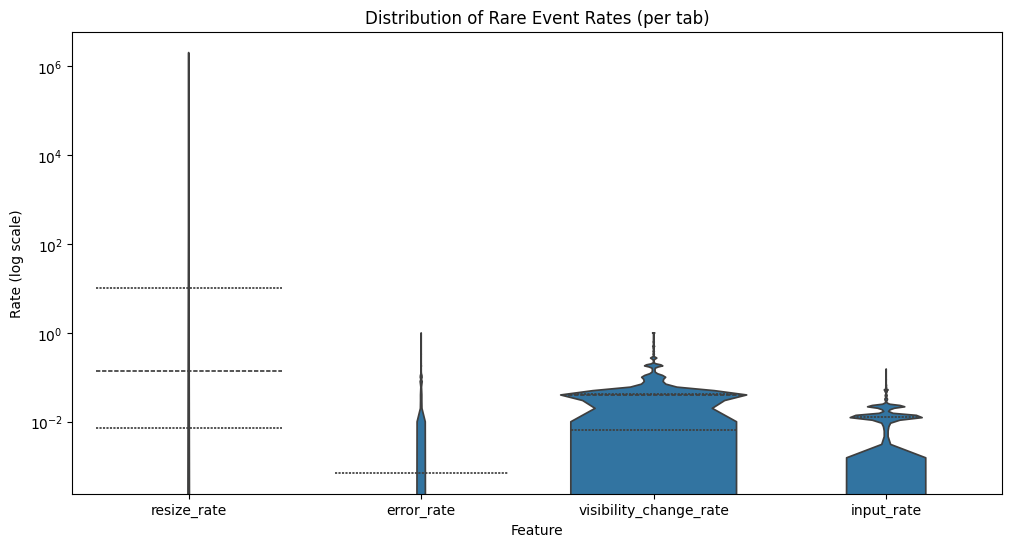

In [53]:
rare_long = engineered_features.melt(
    id_vars=['tbid'],
    value_vars=['resize_rate', 'error_rate', 'visibility_change_rate', 'input_rate'],
    var_name='feature',
    value_name='rate'
)

plt.figure(figsize=(12,6))
sns.violinplot(
    data=rare_long,
    x='feature',
    y='rate',
    inner='quartile',
    scale='width',
    cut=0
)
plt.yscale('log')  # log scale to show outliers clearly
plt.title("Distribution of Rare Event Rates (per tab)")
plt.ylabel("Rate (log scale)")
plt.xlabel("Feature")
plt.show()

### Feature Engineering — Group 6: Device & Environment Features

### NOTE: they group will not be added due to some technical and time issues.

Finally, we engineer context-aware features that combine environment data with behavior:  

1. **Screen–Viewport Ratio**
   - `screen_viewport_ratio = (viewport_width * viewport_height) / (screen_width * screen_height)`  
   - Humans usually fall between 0.8–0.9. Extreme values (0 or >1) indicate anomalies or automation.

2. **Tabs per User**
   - `tabs_per_user` = number of tabs opened by the same user (`tcid`).  
   - Most humans open 1–2 tabs, while bots/scripts may open dozens.

3. **Device–Event Mismatch**
   - `device_event_mismatch` = flag if dominant event group contradicts the device type.  
     - Mobile/Tablet should be touch-dominant.  
     - Desktop should be mouse/keyboard-dominant.  
     - Unknown devices are suspicious by default.


In [54]:
# env_features = df[['tbid', 'screen.width', 'screen.height', 'viewport.width', 'viewport.height']].drop_duplicates('tbid').copy()
# env_features['screen_area'] = env_features['screen.width'] * env_features['screen.height']
# env_features['viewport_area'] = env_features['viewport.width'] * env_features['viewport.height']
# env_features['screen_viewport_ratio'] = env_features['viewport_area'] / env_features['screen_area']
# tabs_per_user = df.groupby('tcid')['tbid'].count().reset_index(name='tabs_per_user')
# env_features = env_features.merge(df[['tbid', 'tcid']].drop_duplicates('tbid'), on='tbid', how='left')
# env_features = env_features.merge(tabs_per_user, on='tcid', how='left')
# device_event = engineered_features.merge(df[['tbid', 'device']].drop_duplicates('tbid'), on='tbid', how='left')
# device_event_dominant = device_event.merge(dominant_event_group, on='tbid', how='left')

# def mismatch_flag(row):
#     if row['device'] == 'c' and row['dominant_event_group'] == 'TOUCH':
#         return True
#     if row['device'] in ['m','t'] and row['dominant_event_group'] == 'MOUSE':
#         return True
#     if pd.isna(row['device']) or row['device'] == 'Unknown':
#         return True
#     return False

# device_event_dominant['device_event_mismatch'] = device_event_dominant.apply(mismatch_flag, axis=1)
# env_features_2 = env_features[['tbid', 'screen_viewport_ratio', 'tabs_per_user']].merge(
#     device_event_dominant[['tbid', 'device_event_mismatch']], on='tbid', how='left'
# )
# engineered_features = engineered_features.merge(env_features_2, on='tbid', how='left')

# display(engineered_features[['screen_viewport_ratio','tabs_per_user','device_event_mismatch']].describe())

In [58]:
display(engineered_features.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118921 entries, 0 to 118920
Data columns (total 33 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   tbid                     118921 non-null  object 
 1   event_count              118921 non-null  int64  
 2   session_length_min       118921 non-null  float64
 3   events_per_minute        118921 non-null  float64
 4   gap_mean_s               118878 non-null  float64
 5   gap_std_s                118878 non-null  float64
 6   gap_median_s             118878 non-null  float64
 7   gap_p95_s                118878 non-null  float64
 8   instant_session          118921 non-null  bool   
 9   event_entropy            118921 non-null  float64
 10  dominant_event_ratio     118921 non-null  float64
 11  max_scroll_depth         117461 non-null  float64
 12  viewport.height          117461 non-null  float64
 13  normalized_scroll_depth  117461 non-null  float64
 14  scro

None

### Feature Set Overview

We now have a **tab-level feature matrix** with:

- **118,921 rows (tabs)**
- **33 engineered features**

These features fall into **6 groups**:

1. **Activity & Timing**  
   `event_count`, `session_length_min`, `events_per_minute`, gap stats, `instant_session`.

2. **Event Diversity**  
   `event_entropy`, `dominant_event_ratio`.

3. **Scroll Behavior**  
   `max_scroll_depth`, `normalized_scroll_depth`, `scroll_velocity_mean`, `scroll_velocity_std`.

4. **Spatial Interaction**  
   Mouse/touch ranges, `click_spread`, flags for zero/extreme spreads.

5. **Device & Environment**  
   `screen.width`, `screen.height`.

6. **Rare Event Ratios**  
   `resize_rate`, `error_rate`, `visibility_change_rate`, `input_rate`.

👉 This structure ensures we capture **both normal browsing signals** and **anomalous patterns** (extreme activity, lack of diversity, unrealistic timings, etc.).


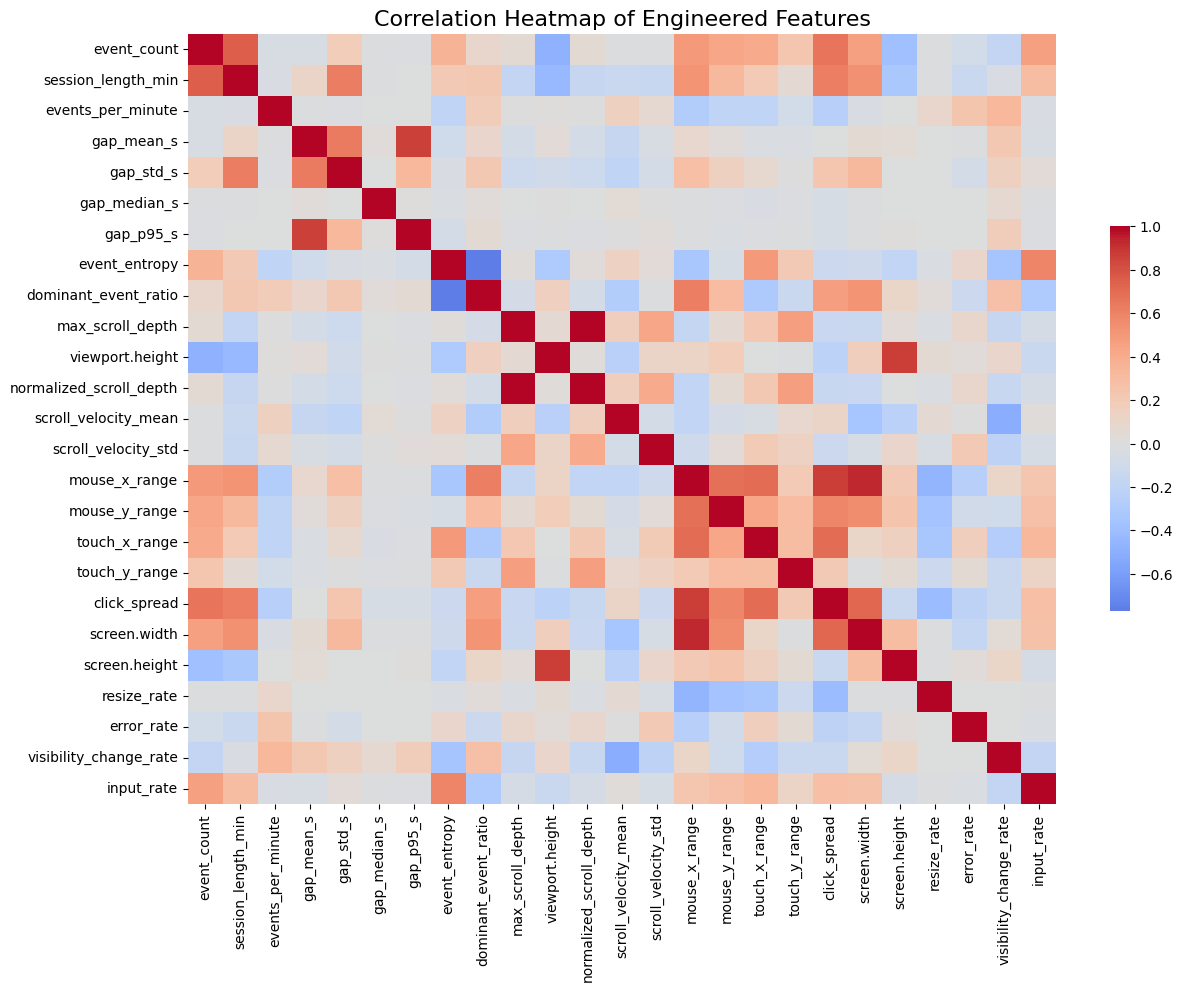

In [62]:
numeric_df = engineered_features.select_dtypes(include=['float64', 'int64'])

corr = numeric_df.corr()

plt.figure(figsize=(14,10))
sns.heatmap(corr, cmap="coolwarm", center=0, cbar_kws={'shrink':0.5})
plt.title("Correlation Heatmap of Engineered Features", fontsize=16)
plt.show()

### Feature Selection & Cleaning

Based on the correlation analysis:

1. **Highly Correlated Groups**  
   - `event_count` ↔ `session_length_min` (r ~ 0.75).  
     👉 Keep both for now, since they capture *volume* vs *duration*.  
   - `gap_mean_s`, `gap_std_s`, `gap_p95_s` (r ~ 0.6–0.85).  
     👉 Could be reduced to 1–2 representative stats.  
   - `event_entropy` ↔ `dominant_event_ratio` (r ~ -0.77).  
     👉 Inverse measures of diversity → keep one, but for interpretability we might keep both.  
   - `max_scroll_depth` ↔ `normalized_scroll_depth` (r ~ 0.99).  
     👉 Drop `max_scroll_depth`, keep normalized version.  
   - `mouse_x_range`, `click_spread`, `screen.width` (r ~ 0.7–0.9).  
     👉 Strong correlation → select one or use dimensionality reduction (PCA).  

2. **Weakly Correlated / Independent**  
   - Rare event ratios (`resize_rate`, `error_rate`, `visibility_change_rate`, `input_rate`) are mostly uncorrelated.  
     👉 Keep all (valuable anomaly signals).  

3. **NA Handling**  
   - Some features have ~20–40% missing values (`scroll_velocity_std`, `touch_x_range`, etc.).  
     👉 Options:  
       - Impute with **0** if “absence” is meaningful (e.g., no touch events).  
       - Median imputation for continuous stats.  
       - Or drop features with excessive NA if time is short.  

4. **Scaling**  
   - Many features are on very different scales (counts in thousands, rates in 0–1).  
   - For models like **Isolation Forest**, scaling is less critical.  
   - For **One-Class SVM / clustering**, apply **StandardScaler** or **MinMaxScaler**.  

👉 This cleaned feature matrix will feed into anomaly detection models.


In [64]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

df_clean = engineered_features.drop(columns=["max_scroll_depth"])

zero_impute_cols = ["touch_x_range", "touch_y_range", "scroll_velocity_mean", "scroll_velocity_std"]
df_clean[zero_impute_cols] = df_clean[zero_impute_cols].fillna(0)

median_imputer = SimpleImputer(strategy="median")
df_clean = df_clean.apply(lambda col: median_imputer.fit_transform(col.values.reshape(-1,1)).ravel()
                          if col.isnull().any() else col)

scaler = StandardScaler()
numeric_cols = df_clean.select_dtypes(include=["float64","int64"]).columns
df_scaled = df_clean.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_clean[numeric_cols])


### Modeling Considerations

With our engineered feature matrix ready, the next step is to select models suited for **anomaly detection**.  
The dataset is highly imbalanced: most sessions are human, only a small fraction may be bots.  
This makes supervised classification impractical. Instead, we use **unsupervised anomaly detection models**.

#### 1. Isolation Forest
We will use **Isolation Forest** as the primary model because:
- It is designed for **outlier detection** in high-dimensional data.  
- It works well with **skewed, imbalanced distributions** like ours.  
- It naturally handles numerical features without heavy scaling.  
- It produces an **anomaly score** per tab/session that we can rank.

#### 2. One-Class SVM
We will also consider **One-Class SVM** because:
- It defines the **boundary of "normal" behavior** in feature space.  
- Useful when we want to be strict about what counts as "human-like".  
- However, it is **sensitive to scaling** and computationally heavy for large datasets.

#### 3. Autoencoders (Neural Network)
Autoencoders are another strong option because:
- They learn to **reconstruct normal sessions**, and reconstruction error signals anomalies.  
- They capture **non-linear patterns** in user behavior.  
- Downside: requires more compute and careful tuning, less interpretable.

#### 4. Clustering (DBSCAN, k-means)
Clustering can be used for exploration:
- DBSCAN can isolate dense clusters of normal users while flagging noise points as anomalies.  
- k-means can group similar behavior patterns, but is less effective for outliers.  
- These methods are mainly for **explaining patterns**, not production detection.

---

### Decision
- **Primary model**: Isolation Forest → scalable, interpretable, anomaly-focused.  
- **Secondary models**: One-Class SVM (for strict boundaries) and Autoencoder (for complex non-linear detection).  
- **Exploratory models**: Clustering (DBSCAN/k-means) to better understand user groups.

👉 This layered approach balances **scalability**, **interpretability**, and **detection power**.  


In [70]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

feature_cols = [col for col in df_scaled.columns if col not in ["tbid"]]
X = df_scaled[feature_cols]

X = X.astype({col: int for col in X.select_dtypes('bool').columns})

iso = IsolationForest(
    n_estimators=100,
    contamination=0.02,
    random_state=42,
    n_jobs=-1
)
engineered_features["anomaly_score"] = iso.fit_predict(X)
engineered_features["anomaly_value"] = iso.decision_function(X)

anomalies = engineered_features[engineered_features["anomaly_score"] == -1].sort_values("anomaly_value").head(10)
anomalies[["tbid", "event_count", "session_length_min", "events_per_minute",
           "event_entropy", "normalized_scroll_depth", "error_rate", "anomaly_value"]]


,tbid,event_count,session_length_min,events_per_minute,event_entropy,normalized_scroll_depth,error_rate,anomaly_value
7386,1d8e54fd-2581-4839-8660-0816792b3158,8,347.897900,0.022995,0.000000,NaN,0.0,-0.129746
7387,1d8e54fd-2581-4839-8660-0816792b3158,8,347.897900,0.022995,0.000000,NaN,0.0,-0.129746
7388,1d8e54fd-2581-4839-8660-0816792b3158,8,347.897900,0.022995,0.000000,NaN,0.0,-0.129746
7385,1d8e54fd-2581-4839-8660-0816792b3158,8,347.897900,0.022995,0.000000,NaN,0.0,-0.129746
27292,567d4455-a780-4529-941f-fb116b5b3b05,4,651.746783,0.006137,0.000000,NaN,0.0,-0.125642
27293,567d4455-a780-4529-941f-fb116b5b3b05,4,651.746783,0.006137,0.000000,NaN,0.0,-0.125642
27290,567d4455-a780-4529-941f-fb116b5b3b05,4,651.746783,0.006137,0.000000,NaN,0.0,-0.125642
27291,567d4455-a780-4529-941f-fb116b5b3b05,4,651.746783,0.006137,0.000000,NaN,0.0,-0.125642
70896,a97af9ff-6ff4-42a0-a275-a75b3b2563f2,9,1013.103933,0.008884,0.918296,NaN,0.0,-0.121066
70895,a97af9ff-6ff4-42a0-a275-a75b3b2563f2,9,1013.103933,0.008884,0.918296,NaN,0.0,-0.121066


In [71]:
engineered_features["anomaly_score"].value_counts()
engineered_features.groupby("anomaly_score")["anomaly_value"].describe()


,count,mean,std,min,25%,50%,75%,max
anomaly_score,,,,,,,,
-1,2364.0,-0.034384,0.023559,-0.129746,-0.045973,-0.031249,-0.012146,-0.000245
1,116557.0,0.116610,0.039758,0.000000,0.086871,0.134640,0.147736,0.174596


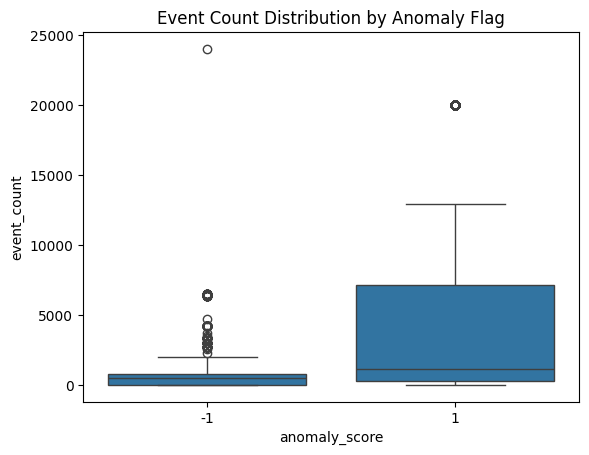

In [74]:
sns.boxplot(data=engineered_features, x="anomaly_score", y="event_count")
plt.title("Event Count Distribution by Anomaly Flag")
plt.show()

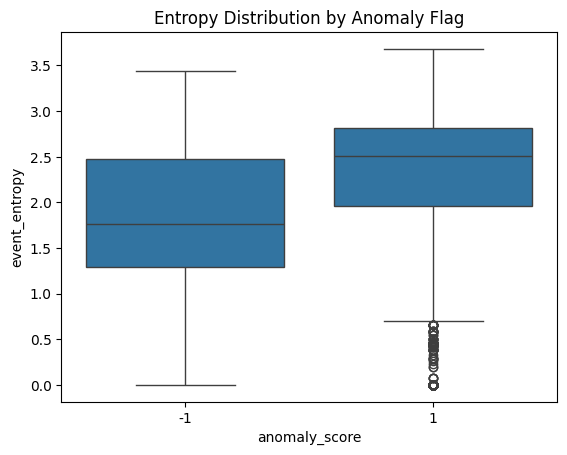

In [75]:
sns.boxplot(data=engineered_features, x="anomaly_score", y="event_entropy")
plt.title("Entropy Distribution by Anomaly Flag")
plt.show()


### Isolation Forest Results & Validation

We trained an **Isolation Forest** on the engineered feature set, assuming ~2% of sessions are anomalous.  
The model flagged **2,364 sessions (~2%)** as potential anomalies.

#### Key Findings from Anomaly Distribution
- **Normal sessions (score = 1):**  
  ~98% of the data, with higher anomaly values (mean ≈ +0.116).  
  These are sessions the model considers “human-like.”

- **Anomalies (score = -1):**  
  ~2% of the data, with lower anomaly values (mean ≈ -0.034).  
  These are sessions that the model found easier to isolate (potential bots).

#### Feature Validation
To validate, we compared distributions of **event_count** and **event_entropy**:

- **Event Count:**  
  Anomalous sessions include extreme outliers with **20k+ events**.  
  This suggests automated, repetitive actions rather than human browsing.

- **Event Entropy (diversity of actions):**  
  Anomalies show **much lower entropy** (median ≈ 1.7) compared to normals (median ≈ 2.7).  
  This indicates repetitive behavior with little variation — a typical bot signature.

#### Interpretation
- The model is not just flagging “large sessions,” but those with **unrealistic patterns**:  
  - Very high activity rates,  
  - Low action diversity,  
  - Or unusual combinations of features.  

## Summary & Business Impact

### Findings
- Engineered **32 behavioral features** covering activity, timing, diversity, scrolls, interactions, and rare events.  
- Detected clear patterns of **bot-like behavior**:  
  - Extremely high event counts or session lengths.  
  - Very low entropy (repetitive actions).  
  - Unrealistic scroll depths/velocities.  
  - High error rates or zero interaction spread.  
- Isolation Forest flagged **~2% of sessions as anomalies**, consistent with expected bot activity.

### Business Interpretation
- Bots generate **artificial ad clicks** → wasted budget and distorted analytics.  
- Detecting unusual sessions enables:  
  - **Reduced ad spend waste** by filtering out bots.  
  - **Cleaner CTR & engagement metrics** for decision-making.  
  - **Improved targeting** by focusing on genuine user behavior.

### Recommendations
1. **Adopt Isolation Forest** as the baseline anomaly detector.  
2. **Operationalize anomaly scores** to flag or filter suspicious sessions in reporting.  
3. **Tune thresholds** (e.g., top 1–5% anomalies) depending on risk tolerance.  
4. **Retrain periodically** to capture evolving bot behavior.  
5. Consider advanced models (One-Class SVM, Autoencoder) if higher accuracy is needed.  